In [ ]:
import jax.numpy as jnp
import matplotlib.pyplot as plt
from jax import grad, lax, jit, tree_map, random, vmap,pmap
import numpy as np

In [ ]:
def phi(h, g=0.4):
  return jnp.tanh(h*g)/g

def dot_phi(h,g=0.4):
  return 1.0 - jnp.tanh(g*h)**2

def ddot_phi(h,g=0.4):
  return - 2*g*jnp.tanh(g*h) * dot_phi(h)

# two layer model
def two_layer_NN_func(params, x, gamma):
  N,D = params[0].shape
  h = 1/jnp.sqrt(D) * params[0] @ x
  return 1/N * phi(h).T @ params[-1] / gamma

# two layer linear
def linear_two_layer_NN_func(params, x, gamma):
  N,D = params[0].shape
  h = 1/jnp.sqrt(D) * params[0] @ x
  return 1/N * h.T @ params[-1] / gamma

# linear net NTK
def linear_compute_NTK(params,x):
  N,D = params[0].shape
  h = 1/jnp.sqrt(D) * params[0] @ x
  phi_h = h
  z = params[1]
  g = z 
  return jnp.mean( phi_h**2 + g**2 )

def compute_NTK(params,x):
  N,D = params[0].shape
  h = 1/jnp.sqrt(D) * params[0] @ x
  phi_h = phi(h)
  z = params[1]
  g = z * dot_phi(h)
  return jnp.mean( phi_h**2 + g**2 )

def compute_NTK_tr_te(params, x, x_test):
  N,D = params[0].shape
  Kt = 1/D * jnp.dot(x, x_test)
  h = 1/jnp.sqrt(D) * params[0] @ x
  hs = 1/jnp.sqrt(D) * params[0] @ x_test
  phi_h = phi(h)
  phi_hs = phi(hs)
  z = params[1]
  g = z * dot_phi(h)
  gs = z * dot_phi(hs)
  return jnp.mean( phi_h * phi_hs + g * gs * Kt )

def compute_NTK_tr_te_multi(params, x, x_test):
  N,D = params[0].shape
  Kt = 1/D * x.T @ x_test
  h = 1/jnp.sqrt(D) * params[0] @ x
  hs = 1/jnp.sqrt(D) * params[0] @ x_test
  phi_h = phi(h)
  phi_hs = phi(hs)
  z = params[1]
  g = z * dot_phi(h)
  gs = z * dot_phi(hs)
  return jnp.mean( phi_h * phi_hs + g * gs * Kt )

def compute_NTK_multi(params, x):
  N,D = params[0].shape
  h = 1/jnp.sqrt(D) * params[0] @ x
  Kx = 1/D * x.T @ x
  phi_h = phi(h)
  z = params[1]
  g = z[:,jnp.newaxis] * dot_phi(h)
  Phi = jnp.einsum('ij,ik->jk',phi_h,phi_h)/phi_h.shape[0]
  G = jnp.einsum('ij,ik->jk',g,g) / g.shape[0]
  return Phi + G * Kx

def compute_kurtosis(params,x):
  N,D = params[0].shape
  h = 1/jnp.sqrt(D) * params[0] @ x
  phi_h = phi(h)
  z = params[1]
  g = z * dot_phi(h)
  return jnp.mean( (phi_h**2 + g**2)**2 ) - jnp.mean( phi_h**2 + g**2 )**2 


def linear_compute_kurtosis(params,x):
  N,D = params[0].shape
  h = 1/jnp.sqrt(D) * params[0] @ x
  phi_h = h
  z = params[1]
  g = z 
  return jnp.mean( (phi_h**2 + g**2)**2 ) - jnp.mean( phi_h**2 + g**2 )**2 

def compute_kurtosis_multi(params,x):
  N,D = params[0].shape
  h = 1/jnp.sqrt(D) * params[0] @ x
  phi_h = phi(h)
  z = params[1]
  g = z[:,jnp.newaxis] * dot_phi(h)
  Phi_s = jnp.einsum('ij,ik->ijk', phi_h,phi_h)
  G_s = jnp.einsum('ij,ik->ijk', g, g)
  kappa = jnp.einsum('ijk,ilm->jklm', Phi_s + G_s,Phi_s+G_s)/Phi_s.shape[0]
  K =jnp.einsum('ij,ik->jk',phi_h,phi_h)/phi_h.shape[0] + jnp.einsum('ij,ik->jk',g,g)/g.shape[0]
  kappa -= jnp.einsum('ij,kl->ijkl', K, K) 
  return kappa

def construct_NN(N, D, key):
  return [random.normal(random.fold_in(key, 1), (N,D)), random.normal( random.fold_in(key, 2), (N,))]

def train_model(params0, apply_fn, x, x_test, y, eta, T=100):   
  loss_fn = lambda params: jnp.mean( ( apply_fn(params,x)- y)**2 )
  Delta_fn = lambda params: y - apply_fn(params,x)
  grad_fn = grad(loss_fn)
  update_fn = lambda params: tree_map(lambda x, g: x - eta*g , params, grad_fn(params))
  update_output_fn = lambda params,input: [update_fn(params), Delta_fn(params)]
  params, Deltas = lax.scan(update_output_fn, params0, xs = None, length = T)
  return params, Deltas

In [ ]:
D = 10
x = random.normal(random.PRNGKey(0), (D,))
x = x / jnp.sqrt(jnp.mean(x**2))
x_test = random.normal(random.PRNGKey(1), (D,)) 
x_test = x_test / jnp.sqrt(jnp.mean(x_test**2)) 
x_test = 0.5 * x + 0.5*x_test
x_test = x_test / jnp.sqrt(jnp.mean(x_test**2)) 

y = 1.0
gamma = 0.5
apply_fn = lambda params,x: two_layer_NN_func(params, x, gamma=gamma)

In [ ]:
N = 10
eta0 = 0.05
eta = N * gamma**2 * eta0
params = construct_NN(N, D, random.PRNGKey(0))
params, Deltas = train_model(params, apply_fn, x, x_test, y, eta = eta)

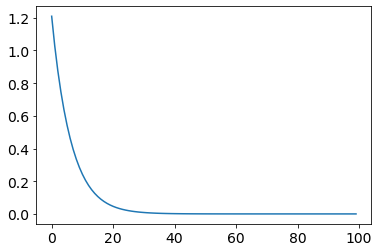

In [ ]:
plt.plot(Deltas)
plt.show()

In [ ]:
from jax.example_libraries import optimizers

def init_and_train(N, gamma, eta0, x, x_test, y, y_test, T=100, E = 100, linear = False):

  apply_fn = lambda params,x: two_layer_NN_func(params, x, gamma=gamma)
  if linear:
    apply_fn = lambda params,x: linear_two_layer_NN_func(params, x, gamma=gamma)

  loss_fn = lambda params, params0: 0.5*jnp.mean( ( apply_fn(params,x) - apply_fn(params0,x) - y)**2 )
  Delta_fn = lambda params, params0: y - apply_fn(params,x) + apply_fn(params0,x)
  Delta_test_fn = lambda params, params0: y_test - apply_fn(params, x_test) + apply_fn(params0,x_test)

  if len(x.shape) == 2:
    print("multi")
    NTK_fn = lambda params: compute_NTK_multi(params,x)
    kappa_fn = lambda params: compute_kurtosis_multi(params,x)

  else:
  
    NTK_fn = lambda params: compute_NTK(params, x)
    kappa_fn = lambda params: compute_kurtosis(params,x)
    if linear:
      NTK_fn = lambda params: linear_compute_NTK(params, x)
      kappa_fn = lambda params: linear_compute_kurtosis(params,x)

  NTK_star_fn = lambda params: compute_NTK_tr_te(params, x, x_test)
  

  grad_fn = grad(loss_fn,0)
  eta_true = N * gamma**2 * eta0

  opt_init, opt_update, get_params = optimizers.sgd(eta_true)
  update_fn = lambda state, state0, t: opt_update(t, grad_fn(get_params(state), get_params(state0)), state)

  def carry_out(ss0, t):
    s, s0 = ss0
    train_Delta = Delta_fn(get_params(s), get_params(s0))
    test_Delta = Delta_test_fn(get_params(s), get_params(s0))
    K = NTK_fn(get_params(s))
    K_star = NTK_star_fn(get_params(s))
    kappa = kappa_fn(get_params(s))
    return [ [update_fn(s,s0,t), s0] , [train_Delta, test_Delta, K, K_star, kappa] ]

  train = lambda ss0: lax.scan(carry_out, ss0, jnp.array(range(T)))
  
  def init_fully(seed, N):
    s =  opt_init(construct_NN(N,D, random.PRNGKey(seed)))
    return [s,s]
  ss_mapped = vmap(init_fully, (0,None))(jnp.array(range(E)), N)
  states_f, Delta_K = vmap(train)(ss_mapped)
  Deltas, Deltas_test, K, K_star, kappa = Delta_K
  return Deltas, Deltas_test, K, K_star, kappa 

def init_and_train_no_test(N, gamma, eta0, x, y, T=100, E = 100, linear = False):

  apply_fn = lambda params,x: two_layer_NN_func(params, x, gamma=gamma)
  if linear:
    apply_fn = lambda params,x: linear_two_layer_NN_func(params, x, gamma=gamma)

  loss_fn = lambda params, params0: 0.5*jnp.mean( ( apply_fn(params,x) - apply_fn(params0,x) - y)**2 )
  Delta_fn = lambda params, params0: y - apply_fn(params,x) + apply_fn(params0,x)

  if len(x.shape) == 2:
    print("multi")
    NTK_fn = lambda params: compute_NTK_multi(params,x)
    kappa_fn = lambda params: compute_kurtosis_multi(params,x)

  else:
  
    NTK_fn = lambda params: compute_NTK(params, x)
    kappa_fn = lambda params: compute_kurtosis(params,x)
    if linear:
      NTK_fn = lambda params: linear_compute_NTK(params, x)
      kappa_fn = lambda params: linear_compute_kurtosis(params,x)
  

  grad_fn = grad(loss_fn,0)
  eta_true = N * gamma**2 * eta0

  opt_init, opt_update, get_params = optimizers.sgd(eta_true)
  update_fn = lambda state, state0, t: opt_update(t, grad_fn(get_params(state), get_params(state0)), state)

  def carry_out(ss0, t):
    s, s0 = ss0
    train_Delta = Delta_fn(get_params(s), get_params(s0))
    K = NTK_fn(get_params(s))
    kappa = kappa_fn(get_params(s))
    return [ [update_fn(s,s0,t), s0] , [train_Delta, K, kappa] ]

  train = lambda ss0: lax.scan(carry_out, ss0, jnp.array(range(T)))
  
  def init_fully(seed, N):
    s =  opt_init(construct_NN(N,D, random.PRNGKey(seed)))
    return [s,s]
  ss_mapped = vmap(init_fully, (0,None))(jnp.array(range(E)), N)
  states_f, Delta_K = vmap(train)(ss_mapped)
  Deltas, K, kappa = Delta_K
  return Deltas, K, kappa

#states = vmap(init_fully)(jnp.array(range(E)))
#out = train([states[0],states[0]])
#states_f, Deltas = vmap(train)(states)

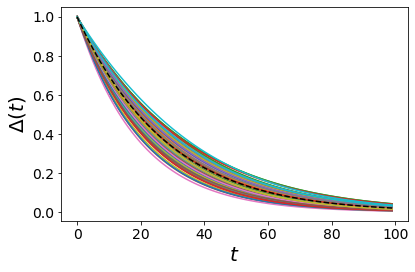

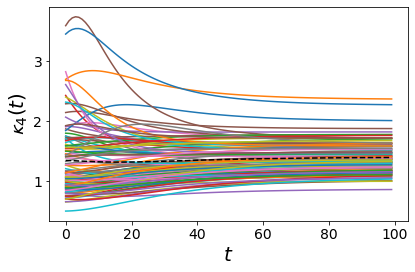

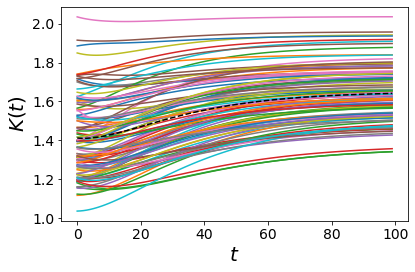

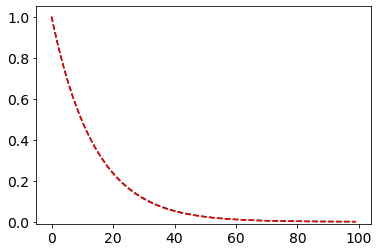

(100, 100)
[6.39488435e-16 2.51261026e-05 9.30066235e-05 1.93633503e-04
 3.18478938e-04 4.60309529e-04 6.13025215e-04 7.71522871e-04
 9.31570365e-04 1.08969968e-03 1.24311133e-03 1.38958241e-03
 1.52739428e-03 1.65525940e-03 1.77226157e-03 1.87779916e-03
 1.97153678e-03 2.05336348e-03 2.12335307e-03 2.18173047e-03
 2.22884491e-03 2.26514181e-03 2.29114108e-03 2.30741967e-03
 2.31459294e-03 2.31330190e-03 2.30420125e-03 2.28794711e-03
 2.26519257e-03 2.23657722e-03 2.20272294e-03 2.16423091e-03
 2.12167460e-03 2.07559881e-03 2.02652044e-03 1.97492377e-03
 1.92126061e-03 1.86595158e-03 1.80938386e-03 1.75191532e-03
 1.69387052e-03 1.63554610e-03 1.57721015e-03 1.51910214e-03
 1.46143790e-03 1.40440580e-03 1.34817557e-03 1.29288994e-03
 1.23867625e-03 1.18564290e-03 1.13387790e-03 1.08345703e-03
 1.03444094e-03 9.86875384e-04 9.40797152e-04 8.96229001e-04
 8.53187172e-04 8.11677775e-04 7.71698949e-04 7.33242312e-04
 6.96295407e-04 6.60837337e-04 6.26845402e-04 5.94291312e-04
 5.63144160e-

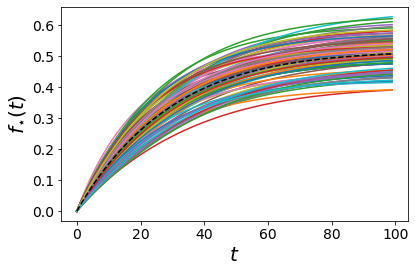

In [ ]:
N = 50
gamma = 1.0
eta0 = 0.025

Deltas, Deltas_test, K, K_star, kappa = init_and_train(N, gamma, eta0, x, x_test, y, 0.0)
Deltas.shape
plt.plot(Deltas.T)
plt.plot(Deltas.mean(axis = 0),'--', color = 'black')
plt.xlabel(r'$t$',fontsize = 20)
plt.ylabel(r'$\Delta(t)$',fontsize = 20)
plt.tight_layout()
plt.savefig('sampled_trajectories_N=%d.pdf'%N)
plt.show()

plt.plot(kappa.T)
plt.plot(kappa.mean(axis=0), '--', color = 'black')
plt.ylabel(r'$\mathcal{\kappa}_4(t)$',fontsize =20)
plt.xlabel(r'$t$',fontsize=20)
plt.tight_layout()
plt.show()

plt.plot(K.T)
plt.plot(K.mean(axis=0), '--', color = 'black')
plt.ylabel(r'$K(t)$',fontsize =20)
plt.xlabel(r'$t$',fontsize=20)
plt.tight_layout()
plt.show()

sqr_err = Deltas**2

#plt.plot(sqr_err.T)
plt.plot(sqr_err.mean(axis = 0),'--', color = 'black')
plt.plot(Deltas.mean(axis = 0)**2, '--', color = 'red')
plt.ylim([-0.01,1.05])
plt.show()
print(Deltas.shape)
var = jnp.mean( (Deltas - Deltas.mean(axis = 0))**2 , axis = 0)
print(var)

plt.plot(-Deltas_test.T)
plt.plot(-Deltas_test.mean(axis = 0),'--', color = 'black')
plt.xlabel(r'$t$',fontsize = 20)
plt.ylabel(r'$f_{\star}(t)$',fontsize = 20)
plt.tight_layout()
plt.savefig('sampled_trajectories_N=%d.pdf'%N)
plt.show()

In [ ]:
Nvals = [25, 50, 100, 500, 1000, 2500, 3200]
all_Deltas = jnp.array([init_and_train(N,gamma,eta0,x,x_test,y, 0.0, E = 1200)[0:2] for N in Nvals])

In [ ]:
print(all_Deltas.shape)

(7, 2, 1200, 100)


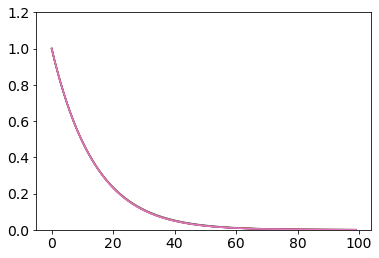

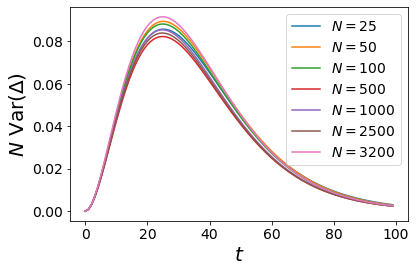

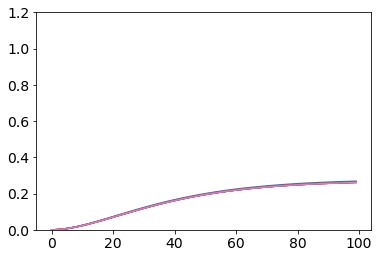

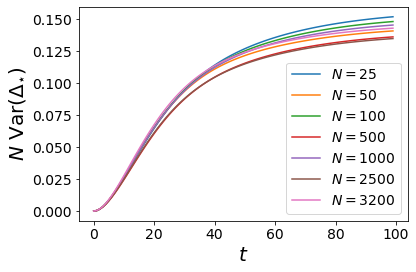

In [ ]:
for i,N in enumerate(Nvals):
  plt.plot(jnp.mean(all_Deltas[i,0]**2,axis=0))
plt.ylim([0,1.2])
plt.show()

for i, N in enumerate(Nvals):
  Delta_i = all_Deltas[i,0]
  var_i = jnp.mean( (Delta_i - Delta_i.mean(axis =0 ))**2, axis = 0)
  plt.plot(var_i * N,label = r'$N = %d$' % N)

plt.xlabel(r'$t$',fontsize =20)
plt.ylabel(r'$N$ Var$(\Delta)$',fontsize = 20)
plt.legend()
plt.tight_layout()
plt.savefig('finite_size_train_err_fluctuations.pdf')
plt.show()

for i,N in enumerate(Nvals):
  plt.plot(jnp.mean(all_Deltas[i,1]**2,axis=0))
plt.ylim([0,1.2])
plt.show()

for i, N in enumerate(Nvals):
  Delta_i = all_Deltas[i,1]
  var_i = jnp.mean( (Delta_i - Delta_i.mean(axis =0 ))**2, axis = 0)
  plt.plot(var_i * N,label = r'$N = %d$' % N)

plt.xlabel(r'$t$',fontsize =20)
plt.ylabel(r'$N$ Var$(\Delta_{\star})$',fontsize = 20)
plt.legend()
plt.tight_layout()
plt.savefig('finite_size_test_err_fluctuations.pdf')
plt.show()

In [ ]:
gamma_vals = [0.001,0.01,0.1,1.0,10.1]
N = 100
all_Deltas = jnp.array([init_and_train(N,gamma,eta0,x, x_test, y,0.0, E = 1200) for gamma in gamma_vals])

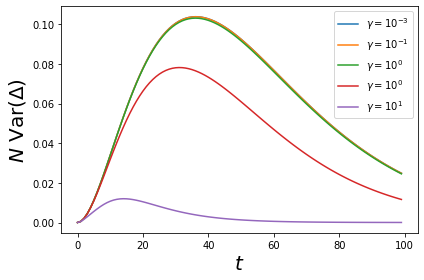

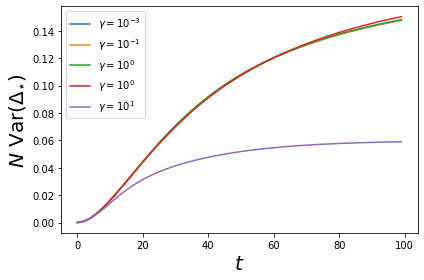

In [ ]:
for i, gamma in enumerate(gamma_vals):
  Delta_i = all_Deltas[i,0]
  var_i = jnp.mean( (Delta_i - Delta_i.mean(axis =0 ))**2, axis = 0)
  plt.plot(var_i * N,label = r'$\gamma = 10^{%d}$' % jnp.log10(gamma))
plt.xlabel(r'$t$',fontsize =20)
plt.ylabel(r'$N$ Var$(\Delta)$',fontsize = 20)
plt.legend()
plt.tight_layout()
plt.savefig('finite_size_train_err_fluctuations_vs_gamma.pdf')
plt.show()

for i, gamma in enumerate(gamma_vals):
  Delta_i = all_Deltas[i,1]
  var_i = jnp.mean( (Delta_i - Delta_i.mean(axis =0 ))**2, axis = 0)
  plt.plot(var_i * N,label = r'$\gamma = 10^{%d}$' % jnp.log10(gamma))
plt.xlabel(r'$t$',fontsize =20)
plt.ylabel(r'$N$ Var$(\Delta_{\star})$',fontsize = 20)
plt.legend()
plt.tight_layout()
plt.savefig('finite_size_test_err_fluctuations_vs_gamma.pdf')
plt.show()

In [ ]:
# solve DMFT equations for 2 layer linear
def linear_dmft(eta, gamma, T, iter = 12, up_speed =0.35):
  eta_gam = eta * gamma
  Deltas = jnp.exp(-2*eta*jnp.linspace(1,T,T))
  tril_low = jnp.tril(jnp.ones((T,T)), k=-1) # for causal integration
  for n in range(iter):
    V = eta_gam * jnp.einsum('ij,j->ij', tril_low, Deltas)
    M = V @ V
    v = jnp.einsum('ij->i', V)
    # compute K through time
    a = jnp.linalg.solve( jnp.eye(T) - M, jnp.ones(T) ) 
    b = jnp.linalg.solve( jnp.eye(T) - M, v)
    K = 2* (a**2 + b**2)
    int_mat = eta * jnp.einsum('ij,j->ij', tril_low, K)
    #f = 2 / gamma * jnp.linalg.solve(jnp.eye(T) - M + 1e-8*jnp.eye(T), v) * jnp.linalg.solve(jnp.eye(T)-M+1e-8*jnp.eye(T), jnp.ones(T))
    f = int_mat @ Deltas
    Deltas = Deltas* (1-up_speed) +  (1.0 - f)*up_speed
  return Deltas


# compute finite size dynamical effect
def linear_dmft_fluctuations(eta, gamma, T, Delta, y = 1.0):

  # compute H(t,s), G(t,s) , R(t,s)
  eta_gam = eta * gamma
  tril_low = jnp.tril(jnp.ones((T,T)), k=-1) # for causal integration
  V = eta_gam * jnp.einsum('ij,j->ij', tril_low, Delta)
  M = V @ V
  # h = (I - M)^{-1} [u 1 + r v], where v(t) = \int_0^t Delta(s) ds
  v = jnp.einsum('ij->i', V)
  
  # h = u a + b * r
  a = jnp.linalg.solve( jnp.eye(T) - M, jnp.ones(T) ) 
  b = jnp.linalg.solve( jnp.eye(T) - M, v)
  # H(t,s) kernel
  H = jnp.outer(a,a) + jnp.outer(b,b)

  K = 2.0 * H

  # R(t,s) = < h(t) z(s) > = (I-M)^{-1}[ gamma *1 v^T + gamma*v 1^T  ]  (I - M)^{-1}
  R = jnp.outer(a,b) + jnp.outer(b,a)
  
  # compute 4th cumulant kappa(t,s) 
  kappa = 4 * H**2 + 4 * R**2
  
  # compute D(t,s) = < d K(t) / d Delta(s) >
  # below is computed with grad flow approximation 
  #D = 4 * eta**2 * gamma**2 * jnp.einsum('ij,j->ij', tril_low, y - 2 * Delta )
  D = 2 * eta_gam * jnp.einsum('i,ij->ij', jnp.exp(2*v) - jnp.exp(-2*v), tril_low)

  # populate entries in matrix  d/dhat{q}(t) dq(s) S 
  Hess_off = np.zeros((2*T,2*T))
  Hess_off[0:T,0:T] = jnp.eye(T) + eta*jnp.einsum('ij,j->ij', tril_low, jnp.diag(K) ) # derivative wrt hat{Delta} and Delta 
  Hess_off[0:T,T:] = eta * jnp.einsum('ij,j->ij', tril_low, Delta)
  Hess_off[T:,0:T] = -1.0 *  D
  Hess_off[T:,T:] = jnp.eye(T)

  block_kappa = np.zeros((2*T,2*T))
  block_kappa[T:,T:] = kappa

  inv_off = jnp.linalg.inv(Hess_off + 1e-2*jnp.eye(2*T))  
  cov_full = inv_off @ block_kappa @ inv_off.T

  Delta_var = cov_full[:T,:T]
  K_var = cov_full[T:,T:]

  return H, kappa, Delta_var, K_var

In [ ]:
eta0 = 0.003
gamma = 0.25
T = 300
Deltas_dmft = linear_dmft(eta0, gamma, T)
print(Deltas_dmft)

[0.9999659  0.9939675  0.98800516 0.98207843 0.9761873  0.9703313
 0.96451044 0.95872444 0.952973   0.9472561  0.94157326 0.9359244
 0.93030936 0.9247278  0.91917956 0.91366446 0.90818226 0.9027328
 0.89731586 0.89193124 0.8865787  0.881258   0.8759692  0.87071174
 0.86548567 0.8602908  0.85512674 0.84999347 0.84489083 0.83981854
 0.8347764  0.82976425 0.82478195 0.81982934 0.8149061  0.8100122
 0.80514735 0.8003115  0.79550433 0.79072577 0.7859756  0.7812536
 0.7765597  0.7718937  0.7672554  0.7626447  0.7580614  0.75350523
 0.7489762  0.74447405 0.7399986  0.7355497  0.73112726 0.7267311
 0.7223611  0.71801686 0.71369857 0.70940584 0.7051387  0.70089674
 0.69668    0.6924883  0.68832153 0.6841794  0.6800619  0.6759689
 0.67190003 0.66785544 0.66383487 0.6598381  0.65586495 0.6519156
 0.6479896  0.6440869  0.6402073  0.6363508  0.63251716 0.6287063
 0.6249181  0.6211523  0.6174089  0.61368775 0.60998863 0.60631144
 0.6026562  0.5990226  0.5954106  0.59182    0.58825076 0.58470273
 0.5

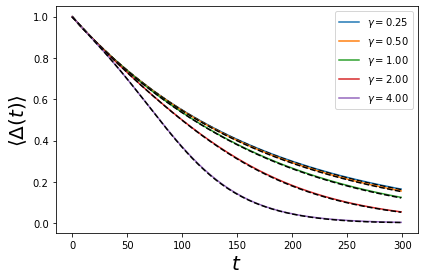

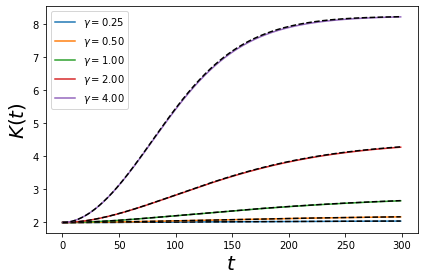

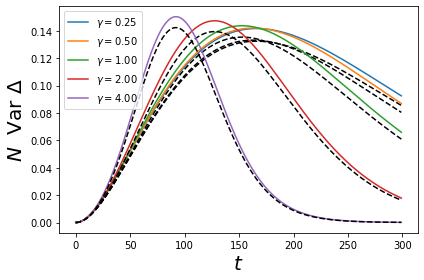

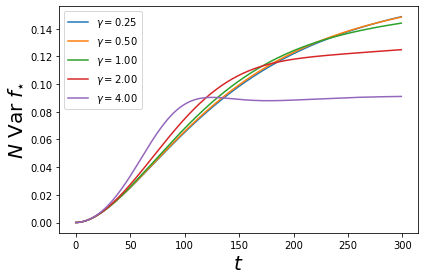

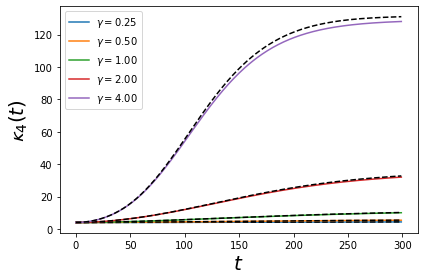

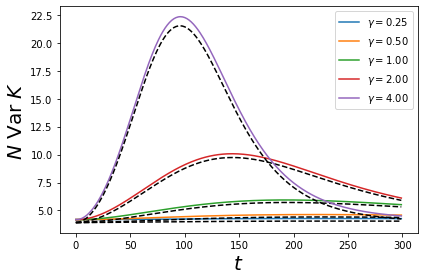

In [ ]:
gamma_vals = [0.25, 0.5, 1.0, 2.0, 4.0]
N = 100

Deltas_expt_all = jnp.array([ init_and_train(N,gamma,eta0,x, x_test, y,0.0, E = 1200, T= T, linear=True) for gamma in gamma_vals ])
kappas_dmft = []
H_dmft = []
all_cov = []
Delta_var_dmft = []
K_var_dmft = []
for i, gamma in enumerate(gamma_vals):
  Deltas_dmft = linear_dmft(eta0, gamma, T)
  H, kappa, Delta_var_i, K_var_i = linear_dmft_fluctuations(eta0, gamma, T, Deltas_dmft) 
  H_dmft += [H]
  kappas_dmft += [kappa]
  Delta_var_dmft += [Delta_var_i]
  K_var_dmft += [K_var_i]

  Deltas_expt = init_and_train(N,gamma,eta0,x, x_test, y,0.0, E = 1200, linear=True)
  plt.plot(Deltas_expt_all[i,0].mean(axis = 0),  color = 'C%d' % i , label = r'$\gamma = %0.2f$' % gamma)
  plt.plot(Deltas_dmft,'--',  color ='black')
plt.ylabel(r'$\left< \Delta(t) \right>$', fontsize=20)
plt.xlabel(r'$t$',fontsize = 20)
plt.legend()
plt.tight_layout()
plt.show()


# plot mean kernel dynamics
for i, gamma in enumerate(gamma_vals):
  plt.plot(Deltas_expt_all[i,2].mean(axis = 0), color = 'C%d' % i,label = r'$\gamma = %0.2f$' % gamma)
  plt.plot(2*jnp.einsum('ii->i',H_dmft[i]), '--', color = 'black')
plt.xlabel(r'$t$',fontsize = 20)
plt.ylabel(r'$K(t)$',fontsize = 20)
plt.legend()
plt.tight_layout()
plt.show()


for i, gamma in enumerate(gamma_vals):
  plt.plot(N * Deltas_expt_all[i,0].var(axis =0), color = 'C%d' % i,label = r'$\gamma = %0.2f$' % gamma)
  plt.plot(jnp.diag(Delta_var_dmft[i]),'--', color = 'black')
plt.ylabel(r'$N$  Var $\Delta$',fontsize = 20)
plt.xlabel(r'$t$',fontsize = 20)
plt.legend()
plt.tight_layout()
plt.savefig('linear_DMFT_Delta_var.pdf')
plt.show()

for i, gamma in enumerate(gamma_vals):
  plt.plot(N * Deltas_expt_all[i,1].var(axis =0), color = 'C%d' % i,label = r'$\gamma = %0.2f$' % gamma)
plt.ylabel(r'$N$ Var $f_{\star}$',fontsize = 20)
plt.xlabel(r'$t$',fontsize = 20)
plt.legend()
plt.tight_layout()
plt.savefig('linear_DMFT_test_point_var.pdf')
plt.show()


# kappas (NTK fourth cumulant)
for i, gamma in enumerate(gamma_vals):
  plt.plot(Deltas_expt_all[i,3].mean(axis =0), color = 'C%d' % i,label = r'$\gamma = %0.2f$' % gamma)
  plt.plot(jnp.einsum('ii->i',kappas_dmft[i]), '--', color = 'black')
plt.ylabel(r'$\mathcal{\kappa}_4(t)$',fontsize = 20)
plt.xlabel(r'$t$',fontsize = 20)
plt.legend()
plt.tight_layout()
plt.savefig('linear_DMFT_kappa_4.pdf')
plt.show()


# compute this!! 
for i, gamma in enumerate(gamma_vals):
  plt.plot(N * Deltas_expt_all[i,2].var(axis =0), color = 'C%d' % i,label = r'$\gamma = %0.2f$' % gamma)
  plt.plot(jnp.einsum('ii->i',K_var_dmft[i]), '--', color = 'black')
plt.ylabel(r'$N$ Var $K$',fontsize = 20)
plt.xlabel(r'$t$',fontsize = 20)
plt.legend()
plt.tight_layout()
plt.savefig('linear_DMFT_K_var.pdf')
plt.show()




#for i, gamma in enumerate(gamma_vals):
#plt.plot(Deltas_expt[i,1].var(axis =0), color = 'C%d' % i)
#plt.show()


In [ ]:
print(N)

100


In [ ]:
# turn these into lax.scan calls

def solve_hz(u, ut, r, Delta, Kt, eta_gam, iter=600):
  T = Delta.shape[0]
  causal = jnp.tril( jnp.ones((T,T)), k=-1 )
  causal_delta = eta_gam * jnp.einsum('ij,j->ij', causal, Delta)
  
  h = jnp.einsum('i,j->ij', u, jnp.ones(T)) # samples x T
  ht = jnp.einsum('i,j->ij', ut, jnp.ones(T))
  z = jnp.einsum('i,j->ij', r, jnp.ones(T)) # samples x T


  for n in range(iter):
    g = dot_phi(h) * z
    gt = dot_phi(ht) * z
    h_new = u[:,jnp.newaxis] + jnp.einsum('ij,kj->ik', g, causal_delta)
    ht_new = ut[:,jnp.newaxis] + jnp.einsum('ij,kj->ik', g, causal_delta) * Kt
    z_new = r[:,jnp.newaxis] + jnp.einsum('ij,kj->ik', phi(h), causal_delta)
    
    if jnp.mean((h-h_new)**2) / jnp.mean(h**2) < 1e-12:
      break
    h =  h_new 
    z = z_new
    ht = ht_new

  return h, z, ht


# compute dh/dDelta and dz /dDelta to get D(t,s) = d/dDelta(s) < phi(t)^2 + g(t)^2 >
def solve_hz_derivs(h,z,ht, Delta, Kt, eta_gam, iter = 600):
  T = h.shape[1]
  # h , z are both samples x T
  dh_dDelta = jnp.zeros((h.shape[0],T,T))
  dz_dDelta = jnp.zeros((h.shape[0],T,T))
  dht_dDelta = jnp.zeros((ht.shape[0],T,T))
  causal = jnp.tril(jnp.ones((T,T)), k=-1)
  causal_Delta = jnp.einsum('ij,j->ij', causal, Delta)
  phi_h = phi(h)
  phit_h = phi(ht)
  g = dot_phi(h) * z
  gt = dot_phi(ht) * z
  for n in range(iter):
    
    # dphi/dDelta = dotphi(h) * dh/dDelta
    dphi_dDelta = jnp.einsum('ijk,ij->ijk', dh_dDelta, dot_phi(h))
    dphit_dDelta = jnp.einsum('ijk,ij->ijk', dht_dDelta, dot_phi(ht))

    # dg/dDelta = ddotphi(h) * z * dh/dDelta + dot_phi * dz/dDelta
    dg_dDelta = jnp.einsum('ijk,ij->ijk', dh_dDelta, ddot_phi(h)*z) + jnp.einsum('ijk,ij->ijk',dz_dDelta, dot_phi(h))
    dgt_dDelta = jnp.einsum('ijk,ij->ijk', dht_dDelta, ddot_phi(ht)*z) + jnp.einsum('ijk,ij->ijk',dz_dDelta, dot_phi(ht))

    # dh(t)/dDelta(s) = gamma * Theta(t-s) g(s) + gamma* int_0^t dt' dg(t') / d_Delta(s) * Delta(t')
    dh_dDelta_new = eta_gam*jnp.einsum('ik,jk->ijk', g, causal) + eta_gam*jnp.einsum('ijk,lj->ilk',dg_dDelta, causal_Delta)
    dht_dDelta_new = eta_gam*jnp.einsum('ik,jk->ijk', g, causal)*Kt + eta_gam*jnp.einsum('ijk,lj->ilk',dg_dDelta, causal_Delta)*Kt

    # dz(t)/dDelta(s) = gamma * Theta(t-s) phi(h(s)) + gamma*int_0^t dt' dphi(t')/d_Delta(s) * Delta(t')
    dz_dDelta_new = eta_gam*jnp.einsum('ik,jk->ijk', phi(h), causal) + eta_gam * jnp.einsum('ijk,lj->ilk',dphi_dDelta, causal_Delta)

    if jnp.mean( (dh_dDelta_new - dh_dDelta)**2 ) / jnp.mean( dh_dDelta**2 ) < 1e-12:
      break
    
    dh_dDelta = dh_dDelta_new
    dz_dDelta = dz_dDelta_new
    dht_dDelta = dht_dDelta_new

  D = 2*jnp.einsum('ijk,ij->jk', dphi_dDelta, phi_h)/phi_h.shape[0] + 2*jnp.einsum('ijk,ij->jk', dg_dDelta, g)/g.shape[0] 
  Dt = jnp.einsum('ijk,ij->jk', dphi_dDelta, phit_h)/phi_h.shape[0] + jnp.einsum('ijk,ij->jk', dphit_dDelta, phi_h)/phi_h.shape[0]
  Dt += Kt*jnp.einsum('ijk,ij->jk', dg_dDelta, gt)/g.shape[0] + Kt*jnp.einsum('ijk,ij->jk', dgt_dDelta, g)/g.shape[0]
  return D, Dt

# 2 layer DMFT equations
def solve_DMFT(y, Kt, eta, gamma, iter = 45, samples = 2500, seed = 0, T =100, beta = 0.6, return_D = False):
  key = random.PRNGKey(seed)
  key_u, key_ut, key_r = random.split(key,3)
  u = random.normal(random.fold_in(key_u,-1), (samples,))
  u0 = random.normal(random.fold_in(key_ut,-1), (samples,))
  ut = Kt * u + jnp.sqrt(1.0 - Kt**2) * u0
  
  # initial guess for K, Kt (lazy solution)
  K = (jnp.mean( phi(u)**2 ) + jnp.mean( dot_phi(u)**2  ) )*jnp.ones(T)
  K_star = (jnp.mean( phi(u)*phi(ut) + Kt * dot_phi(u) * dot_phi(ut)) )*jnp.ones(T)

  causal = jnp.tril(jnp.ones((T,T)),k=-1)
  Delta = jnp.linalg.solve(jnp.eye(T) - eta*jnp.einsum('ij,j->ij',causal,K), y*jnp.ones(T))
  ft = eta*jnp.einsum('ij,j->i', causal, Delta*K_star) # output prediction
  kappa = jnp.zeros((T,T))
  kappa_star = jnp.zeros((T,T))
  kappa_star_star = jnp.zeros((T,T))
  D = jnp.zeros((T,T))
  Dt = jnp.zeros((T,T))
  for n in range(iter):
    
    u = random.normal(random.fold_in(key_u,n+1), (samples,)) # train
    u0t = random.normal(random.fold_in(key_ut,n+1), (samples,)) # test
    ut = Kt * u + jnp.sqrt(1.0 - Kt**2) * u0t
    r = random.normal(random.fold_in(key_r,n+1), (samples,))
    h, z, ht = solve_hz(u, ut, r, Delta, Kt, eta*gamma)
    g = dot_phi(h) * z
    phi_s = phi(h)
    phit_s = phi(ht)
    gt = dot_phi(ht) * z
    K_new = jnp.einsum('ij,ij->j', phi_s, phi_s)/samples + jnp.einsum('ij,ij->j',g,g)/samples
    K_star_new = jnp.einsum('ij,ij->j', phi_s, phit_s)/samples + Kt * jnp.einsum('ij,ij->j',g, gt)/samples
    #plt.plot(jnp.einsum('ij,ij->j', phi_s, phi_s)/samples)
    #plt.show()
    # Delta(t) - y = - int_0^t ds K(s) Delta
    Delta_new = jnp.linalg.solve(jnp.eye(T) + eta*jnp.einsum('ij,j->ij',causal, K), y*jnp.ones(T))
    ft_new = eta*jnp.einsum('ij,j->i', causal, Delta * K_star) # output prediction f_star(t) = \int_0^t ds Delta(s) K(s)

    K = beta * K_new + (1.0-beta) * K
    K_star = beta * K_star_new + (1.0-beta) * K_star
    #Delta_new = y - 1.0/gamma*jnp.mean( z*phi(h), axis=0)
    Delta = beta * Delta_new + (1-beta) * Delta
    ft = beta*ft_new + (1-beta)*ft
    # calculate NTK fourth cumulant , assume |x|^2 = D
    k_i = phi_s**2 + g**2 
    k_i_star = phi_s * phit_s + g * gt * Kt
    #K = k_i.mean(axis = 0) 
    kappa_new = jnp.einsum('ij,ik->jk', k_i, k_i) / k_i.shape[0] - jnp.einsum('i,j->ij', K,K)
    kappa = beta*kappa_new + (1.0-beta) * kappa
    # cov(K_star, K)
    kappa_star_new = jnp.einsum('ij,ik->jk', k_i_star, k_i) / k_i.shape[0] - jnp.einsum('i,j->ij', K_star, K)
    kappa_star = beta*kappa_star_new + (1.0-beta) * kappa_star
    # cov(K_star, K_star)
    kappa_star_star_new = jnp.einsum('ij,ik->jk', k_i_star, k_i_star) / k_i.shape[0] - jnp.einsum('i,j->ij', K_star, K_star)
    kappa_star_star = beta * kappa_star_star_new + (1.0-beta) * kappa_star_star
  
    if n % 10 ==0:
      plt.plot(Delta)
      plt.show()
      # compute D(t,s), D_{star}(t,s)
      D_new, Dt_new = solve_hz_derivs(h, z, ht, Delta, Kt, eta*gamma)
      D = beta * D_new + (1-beta) * D
      Dt = beta * Dt_new + (1-beta)* Dt_new
  
  # calculate dh/d Delta and d z/d Delta
  D_new, Dt_new = solve_hz_derivs(h, z, ht, Delta, Kt, eta*gamma)
  D = beta * D_new + (1-beta) * D
  Dt = beta * Dt_new + (1-beta)* Dt_new
  plt.plot(D[:,0])
  plt.plot(D[:,10])
  plt.ylabel(r'$D(t,0)$')
  plt.show()

  causal_Delta = jnp.einsum('ij,j->ij', causal, Delta)
  # calculate Schur complement
  #S = jnp.linalg.inv( jnp.eye(T) + eta*jnp.einsum('ij,j->ij',causal, K) - eta*causal_Delta @ D )
  #S = jnp.linalg.inv(jnp.eye(T) + eta * jnp.einsum('ij,j->ij', causal,K))

  plt.plot(K_star)
  plt.ylabel(r'$K_{\star}$')
  plt.show()
  
  # TODO!: try to do a larger 4 x 4 block system for the test point
  kappa_block = np.zeros((4*T,4*T))
  kappa_block[2*T:3*T,2*T:3*T] = kappa
  kappa_block[3*T:4*T,2*T:3*T] = kappa_star
  kappa_block[2*T:3*T,3*T:4*T] = kappa_star.T
  kappa_block[3*T:4*T,3*T:4*T] = kappa_star_star
  
  off_diag_block = np.zeros((4*T,4*T))
  # first row Delta(t)
  off_diag_block[:T,:T] = jnp.eye(T) + eta * jnp.einsum('ij,j->ij', causal, K) # partial_{hatDelta, Delta}
  off_diag_block[:T,2*T:3*T] = eta * jnp.einsum('ij,j->ij', causal, Delta) # partial_{hat Delta, K}
  # second row f_star(t)
  off_diag_block[T:2*T,:T] = -eta * jnp.einsum('ij,j->ij', causal, K_star) # d^2 S/d{hat f_*} dDelta(s)
  off_diag_block[T:2*T,T:2*T] = jnp.eye(T) # d^2 S / dhat{f_*} df_*
  off_diag_block[T:2*T,3*T:4*T] = -eta * jnp.einsum('ij,j->ij', causal, Delta) # d^2 S/dhat{f} dK_star(s)
  # third row K(t)
  off_diag_block[2*T:3*T,:T] = -1.0* D # - dK(t)/dDelta(s)
  off_diag_block[2*T:3*T,2*T:3*T] = jnp.eye(T)
  # fourth row K_star(t)
  off_diag_block[3*T:4*T,:T] = -1.0* Dt # - dK_star(t) / dDelta(s)
  off_diag_block[3*T:4*T,3*T:4*T] = jnp.eye(T) 

  inv_off = jnp.linalg.inv(off_diag_block)
  full_cov = inv_off @ kappa_block @ inv_off.T
  Delta_cov = full_cov[:T,:T]
  K_cov = full_cov[2*T:3*T,2*T:3*T]
  K_star_cov = full_cov[3*T:4*T,3*T:4*T] 
  f_star_cov = full_cov[T:2*T,T:2*T]

  """
  # compute propagator by solving linear system
  kappa_block = np.zeros((2*T,2*T))
  kappa_block[T:,T:] = kappa

  #D = jnp.zeros((T,T))
  off_diag_block = np.zeros((2*T,2*T))
  off_diag_block[:T,:T] = jnp.eye(T) + eta * jnp.einsum('ij,j->ij', causal, K) # partial_{hatDelta, Delta}
  off_diag_block[:T,T:] = eta * causal_Delta # partial_{}
  off_diag_block[T:,:T] = -1.0*D
  off_diag_block[T:,T:] = jnp.eye(T)

  inv_off = jnp.linalg.inv(off_diag_block)
  full_cov = inv_off @ kappa_block @ inv_off.T

  Delta_cov = full_cov[:T,:T]
  K_cov = full_cov[T:,T:]
  """
  #plt.plot(jnp.diag(kappa))
  #plt.show()
  # compute filtered kappa
  #filt_kappa = eta**2 * causal_Delta @ kappa @ causal_Delta.T
  #Delta_cov = S @ filt_kappa @ S.T
  #K_cov = (jnp.eye(T) + D @ S) @ filt_kappa @ (jnp.eye(T) + D @ S).T
  if return_D == False:
    return Delta, ft, K, K_star, jnp.diag(Delta_cov), jnp.diag(f_star_cov), jnp.diag(K_cov), jnp.diag(K_star_cov), jnp.diag(kappa)

  return Delta, ft, K, K_star, jnp.diag(Delta_cov), jnp.diag(f_star_cov), jnp.diag(K_cov), jnp.diag(K_star_cov), jnp.diag(kappa), D, Dt
# lazy limit
def compute_finite_correction_lazy(y, eta, T=100, samples = 2000):
  key = random.PRNGKey(0)
  key_u, key_r = random.split(key)
  u = random.normal(random.fold_in(key_u,-1), (samples,))
  r = random.normal(random.fold_in(key_r,-1), (samples,)) 
  K = jnp.mean( phi(u)**2 ) + jnp.mean( dot_phi(u)**2 )
  kappa = jnp.mean( ( phi(u)**2 + r**2 * dot_phi(u)**2 )**2 ) - K**2
  tvals = jnp.linspace(0,T,T)
  Delta_var = kappa * y**2 *(eta*tvals)**2 * jnp.exp(-2 * eta * tvals * K )
  return Delta_var

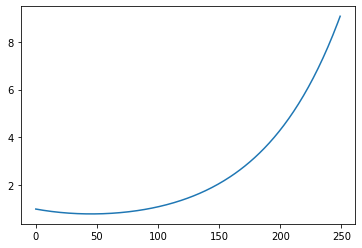

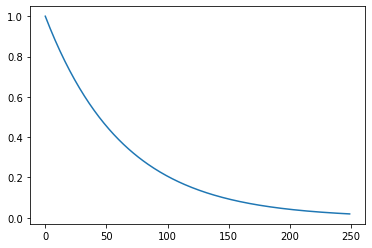

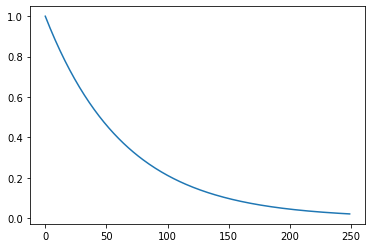

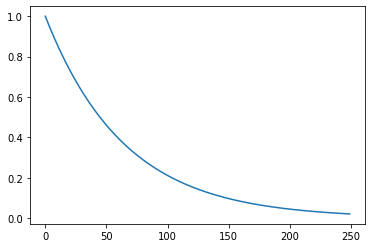

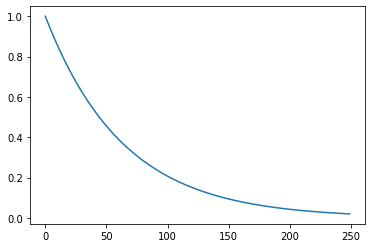

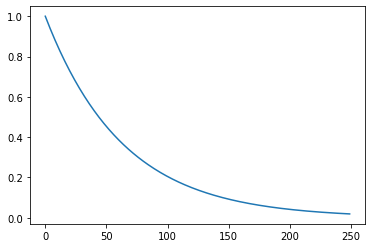

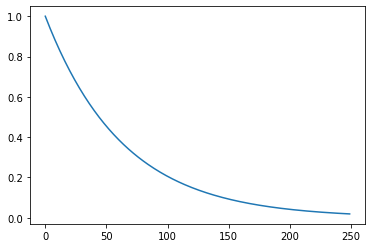

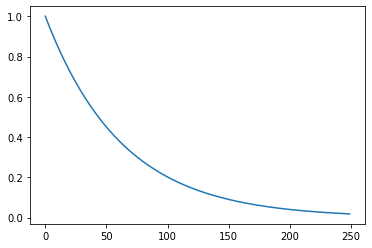

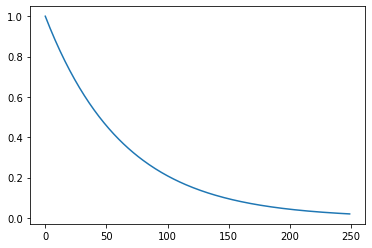

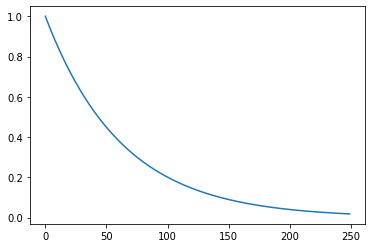

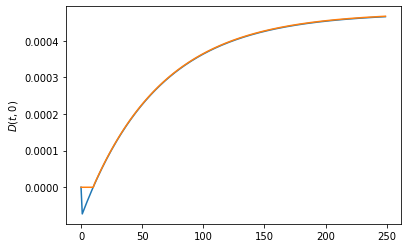

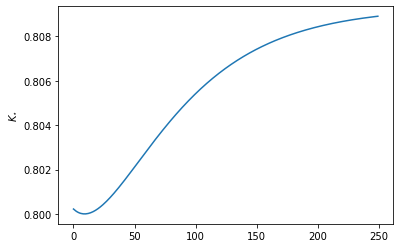

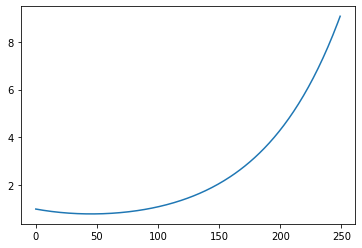

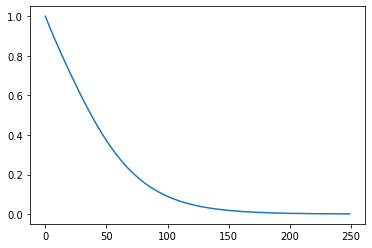

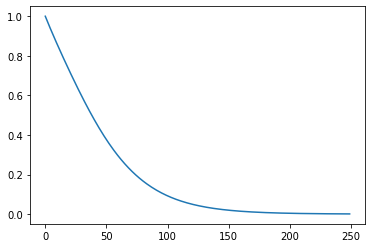

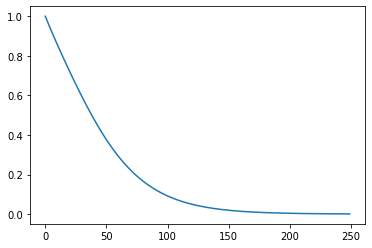

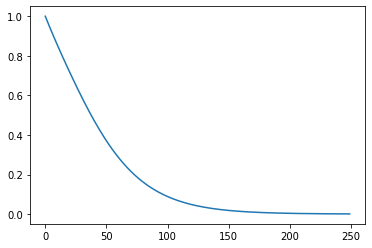

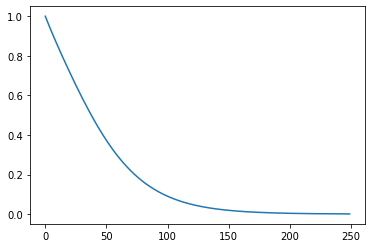

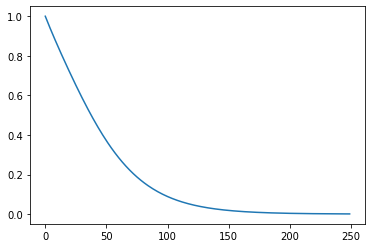

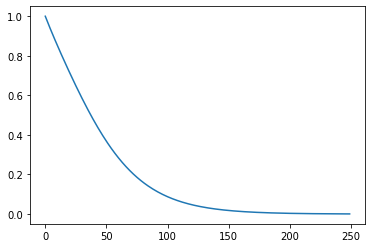

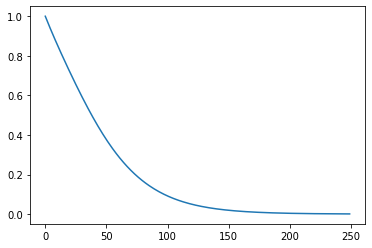

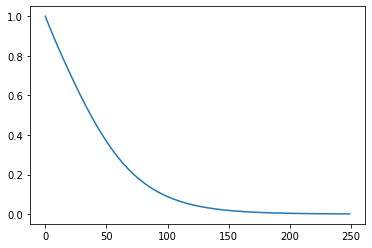

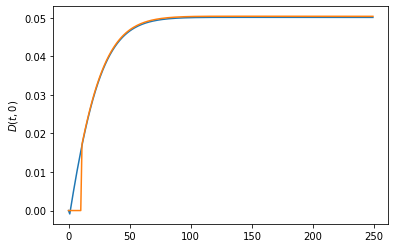

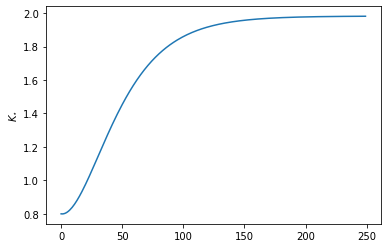

In [ ]:
eta = 0.01
gamma_lazy = 0.2
gamma_rich = 3.0
T = 250
Kt = jnp.dot(x, x_test) / x.shape[0]
Delta_lazy, ft_lazy, K_lazy, K_star_lazy, Delta_lazy_cov, f_star_cov_lazy, K_lazy_cov, K_star_lazy_cov, kappa_lazy = solve_DMFT(y, Kt=Kt, eta=eta, gamma=gamma_lazy, samples = 3600, beta = 0.8, iter = 100, T=T)
Delta_rich, ft_rich, K_rich, K_star_rich, Delta_rich_cov, f_star_cov_rich, K_rich_cov, K_star_rich_cov, kappa_rich = solve_DMFT(y, Kt=Kt, eta=eta, gamma=gamma_rich, samples = 3600, beta = 0.8, iter = 100, T=T)

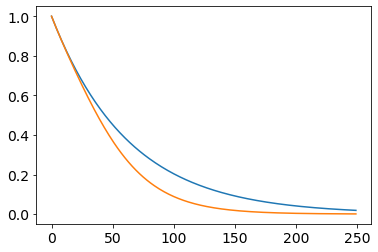

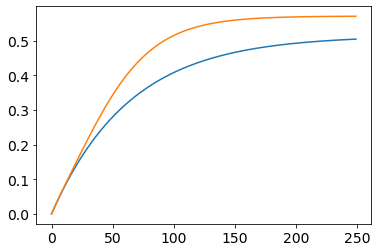

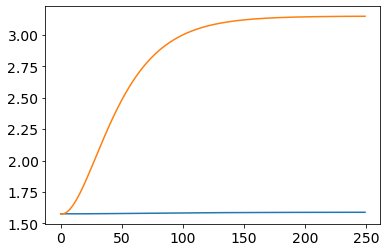

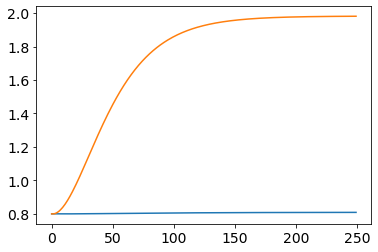

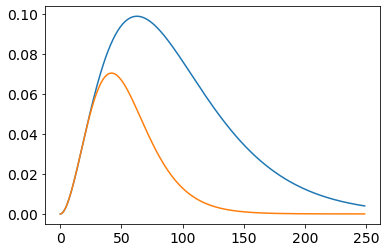

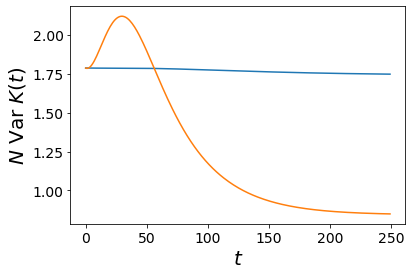

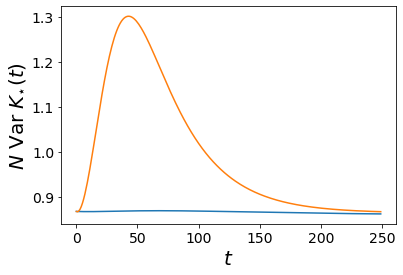

In [ ]:
plt.plot(Delta_lazy)
plt.plot(Delta_rich)
plt.show()

plt.plot(ft_lazy)
plt.plot(ft_rich)
plt.show()

plt.plot(K_lazy)
plt.plot(K_rich)
plt.show()
plt.plot(K_star_lazy)
plt.plot(K_star_rich)
plt.show()


plt.plot(Delta_lazy_cov)
plt.plot(Delta_rich_cov)
plt.show()

plt.plot(K_lazy_cov, label = r'Lazy')
plt.plot(K_rich_cov, label = r'Rich')
plt.xlabel(r'$t$',fontsize = 20)
plt.ylabel(r'$N$ Var $K(t)$',fontsize = 20)
plt.show()


plt.plot(K_star_lazy_cov, label = r'Lazy')
plt.plot(K_star_rich_cov, label = r'Rich')
plt.xlabel(r'$t$',fontsize = 20)
plt.ylabel(r'$N$ Var $K_{\star}(t)$',fontsize = 20)
plt.show()

In [ ]:
N = 256
Delta_expt_rich, ft_expt_rich, K_expt_rich, K_star_expt_rich, kappa_expt_rich = init_and_train(N=N,gamma=gamma_rich, eta0=eta,x=x,y=y, x_test=x_test,y_test=0.0, E = 3000, T = T) 
Delta_expt_lazy, ft_expt_lazy, K_expt_lazy, K_star_expt_lazy, kappa_expt_lazy = init_and_train(N=N,gamma=gamma_lazy, eta0=eta,x=x,y=y,x_test=x_test,y_test=0.0, E = 3000, T=T) 

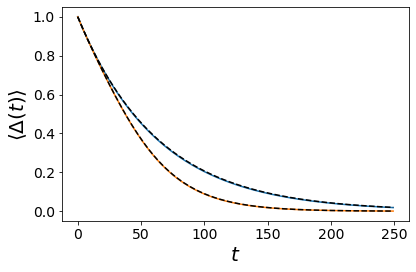

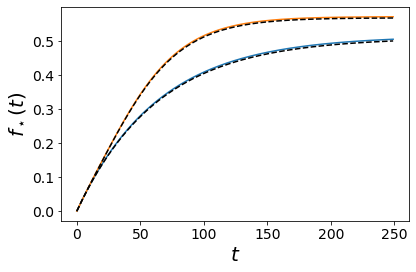

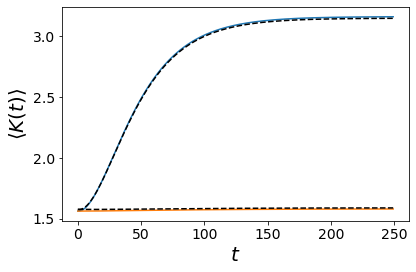

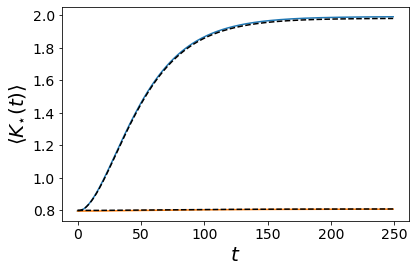

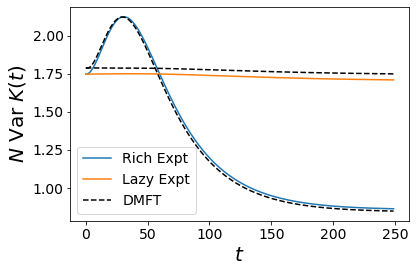

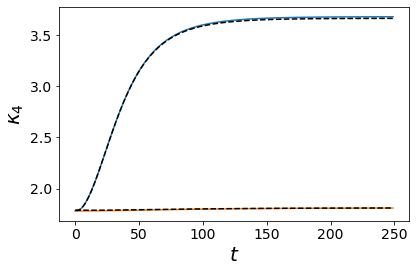

In [ ]:
plt.rcParams.update({'font.size': 14})
plt.plot(Delta_lazy)
plt.plot(Delta_rich)
plt.plot(Delta_expt_rich.mean(axis=0),'--', color = 'black')
plt.plot(Delta_expt_lazy.mean(axis=0),'--', color = 'black')
plt.xlabel(r'$t$',fontsize=20)
plt.ylabel(r'$\left< \Delta(t) \right>$',fontsize=20)
plt.tight_layout()
plt.show()

plt.rcParams.update({'font.size': 14})
plt.plot(ft_lazy)
plt.plot(ft_rich)
plt.plot(-ft_expt_rich.mean(axis=0),'--', color = 'black')
plt.plot(-ft_expt_lazy.mean(axis=0),'--', color = 'black')
plt.xlabel(r'$t$',fontsize=20)
plt.ylabel(r'$f_\star(t)$',fontsize=20)
plt.tight_layout()
plt.show()

plt.rcParams.update({'font.size': 14})
plt.plot(K_expt_rich.mean(axis=0))
plt.plot(K_expt_lazy.mean(axis=0))
plt.plot(K_lazy, '--', color = 'black')
plt.plot(K_rich, '--', color = 'black')
plt.xlabel(r'$t$',fontsize=20)
plt.ylabel(r'$\left< K(t) \right>$',fontsize=20)
plt.tight_layout()
plt.show()


plt.rcParams.update({'font.size': 14})
plt.plot(K_star_expt_rich.mean(axis=0))
plt.plot(K_star_expt_lazy.mean(axis=0))
plt.plot(K_star_lazy, '--', color = 'black')
plt.plot(K_star_rich, '--', color = 'black')
plt.xlabel(r'$t$',fontsize=20)
plt.ylabel(r'$\left< K_{\star}(t) \right>$',fontsize=20)
plt.tight_layout()
plt.show()

plt.plot(N*K_expt_rich.var(axis=0), label = 'Rich Expt')
plt.plot(N*K_expt_lazy.var(axis=0), label ='Lazy Expt')
plt.plot(K_lazy_cov, '--', label = r'DMFT', color = 'black')
plt.plot(K_rich_cov, '--', color = 'black')
plt.plot()
plt.xlabel(r'$t$',fontsize = 20)
plt.ylabel(r'$N$ Var $K(t)$',fontsize = 20)
plt.legend()
plt.tight_layout()
plt.savefig('NTK_var_rich_lazy.pdf')
plt.show()

plt.plot(kappa_expt_rich.mean(axis=0))
plt.plot(kappa_expt_lazy.mean(axis=0))
plt.plot(kappa_rich,'--', color = 'black')
plt.plot(kappa_lazy, '--', color = 'black')
plt.xlabel(r'$t$',fontsize = 20)
plt.ylabel(r'$\kappa_4$',fontsize = 20)
plt.tight_layout()
plt.savefig(r'kappa_4_theory.pdf')
plt.show()

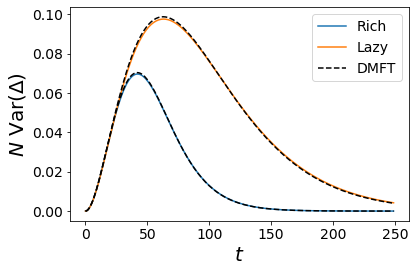

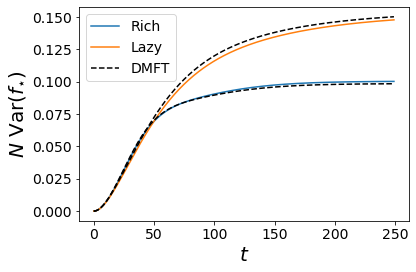

In [ ]:
plt.plot(N*Delta_expt_rich.var(axis=0), label = 'Rich')
plt.plot(N*Delta_expt_lazy.var(axis = 0), label = 'Lazy')
plt.plot(Delta_lazy_cov, '--', color = 'black', label = 'DMFT')
plt.plot(Delta_rich_cov, '--', color = 'black')
plt.legend()
plt.xlabel(r'$t$',fontsize =20)
plt.ylabel(r'$N$ Var$(\Delta)$',fontsize=20)
plt.tight_layout()
plt.savefig('train_pred_var.pdf')
plt.show()

plt.plot(N*ft_expt_rich.var(axis=0), label = 'Rich')
plt.plot(N*ft_expt_lazy.var(axis = 0), label = 'Lazy')
plt.plot(f_star_cov_lazy, '--', color = 'black', label = 'DMFT')
plt.plot(f_star_cov_rich, '--', color = 'black')
plt.legend()
plt.xlabel(r'$t$',fontsize =20)
plt.ylabel(r'$N$ Var$(f_{\star})$',fontsize=20)
plt.tight_layout()

plt.savefig('test_pred_var.pdf')
plt.show()

xt * x = 0.5156 | Kt = 0.5156


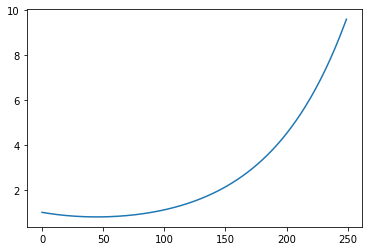

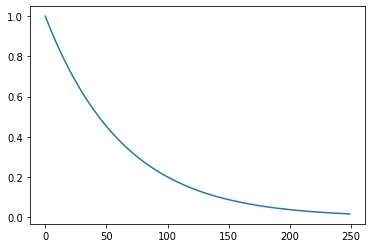

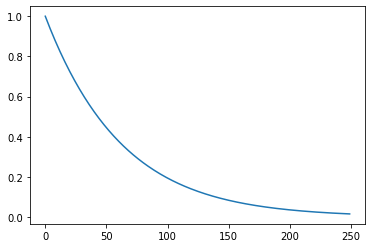

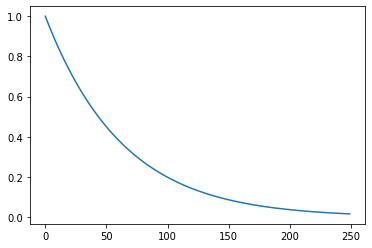

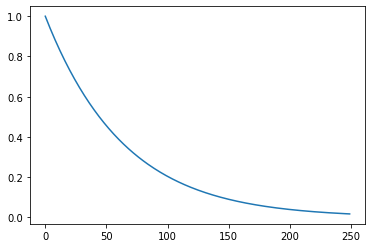

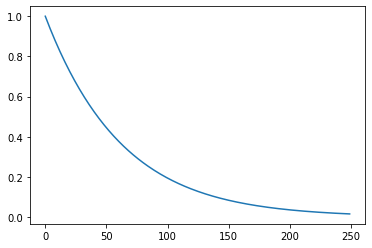

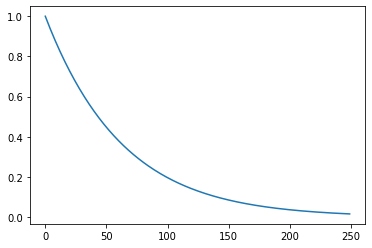

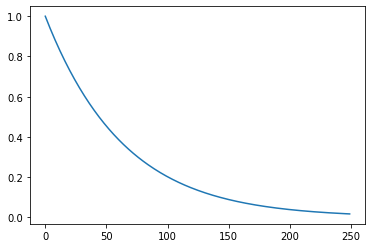

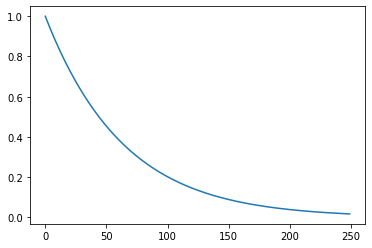

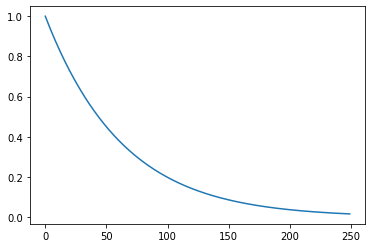

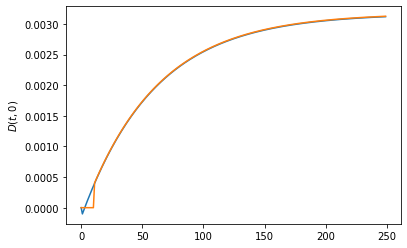

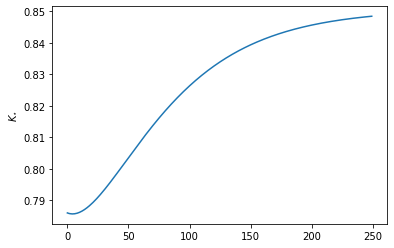

xt * x = 0.5156 | Kt = 0.5156


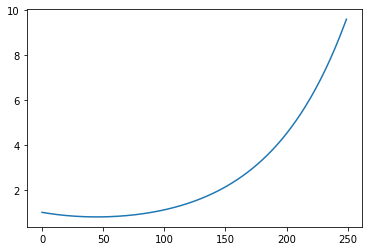

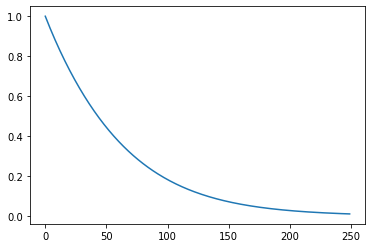

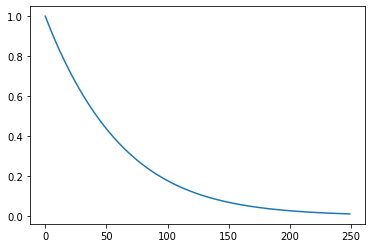

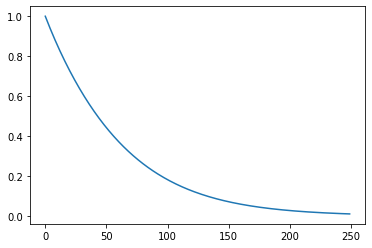

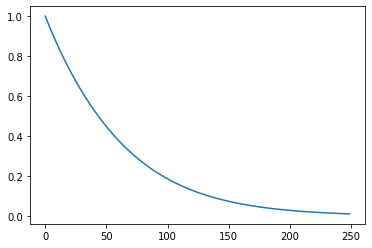

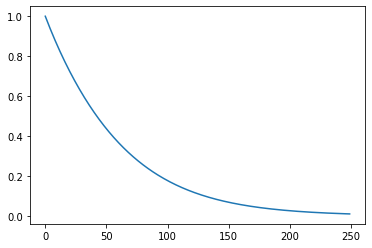

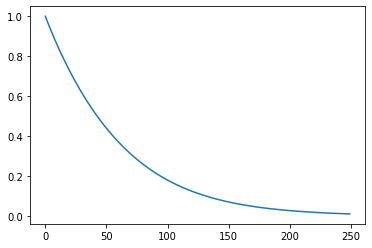

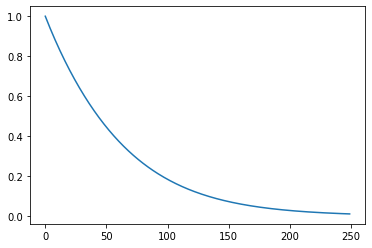

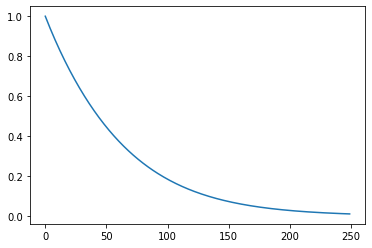

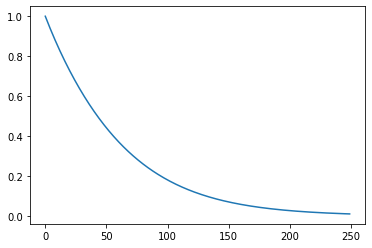

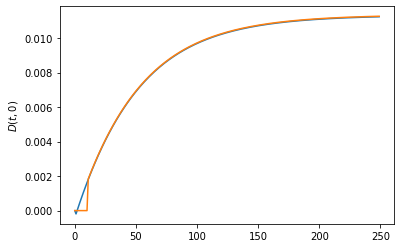

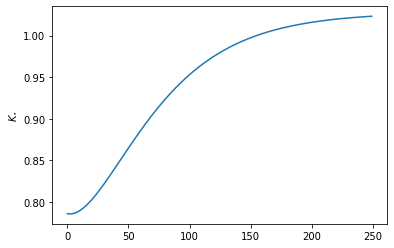

xt * x = 0.5156 | Kt = 0.5156


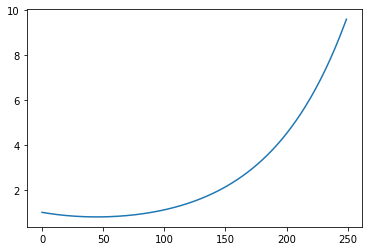

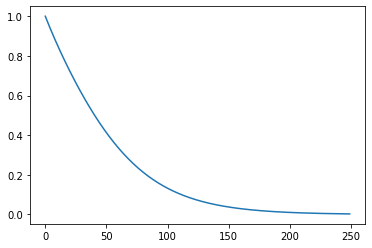

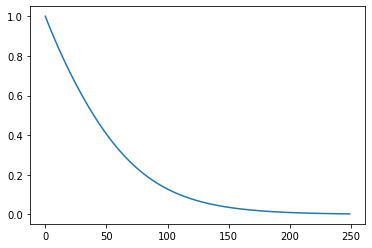

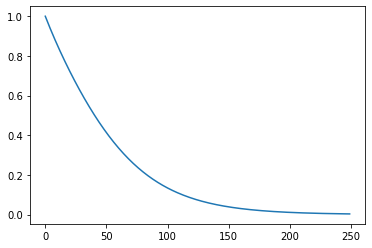

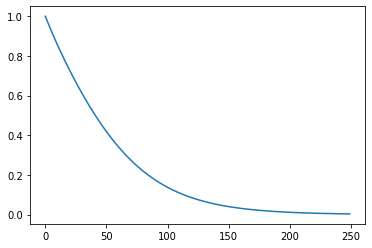

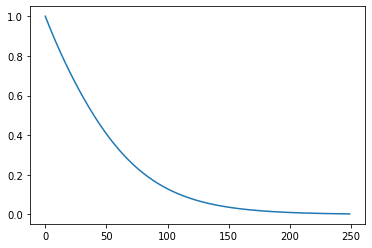

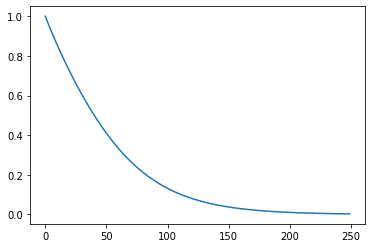

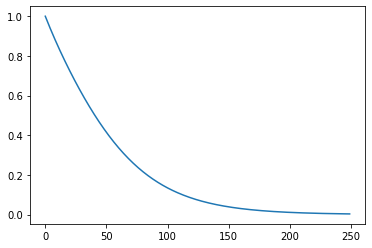

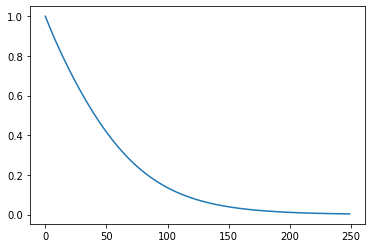

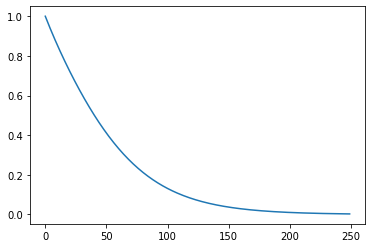

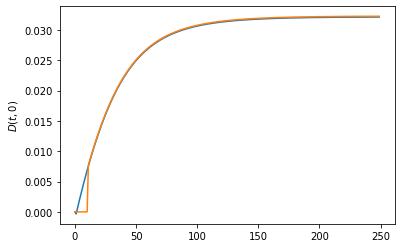

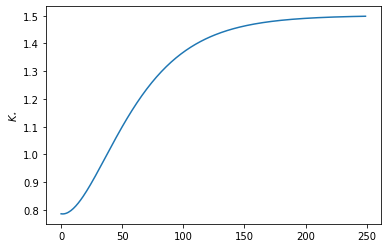

xt * x = 0.5156 | Kt = 0.5156


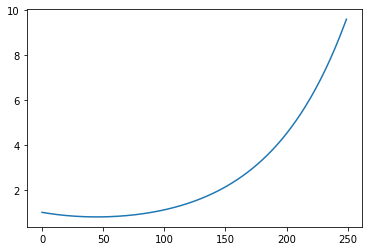

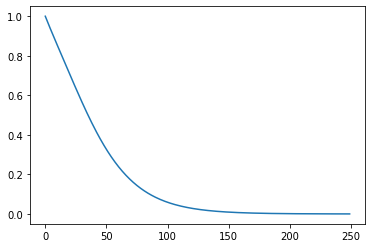

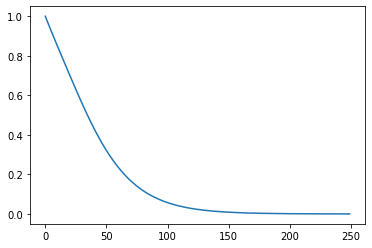

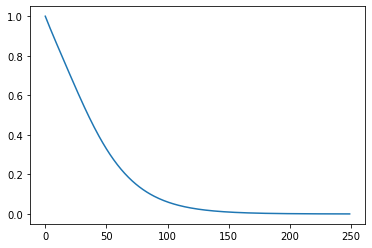

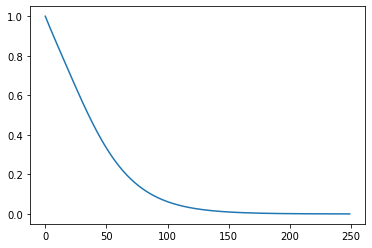

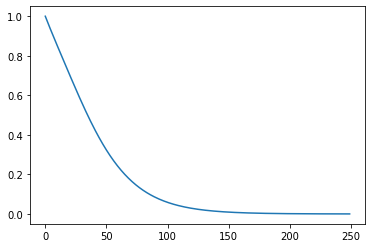

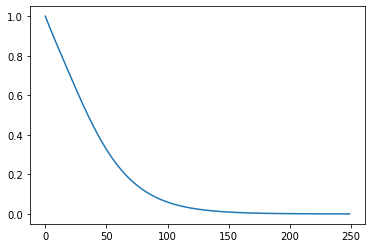

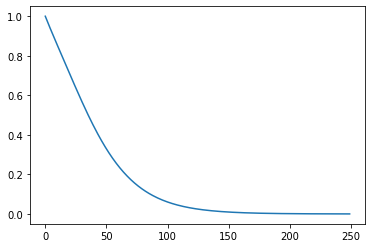

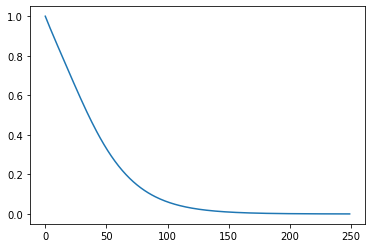

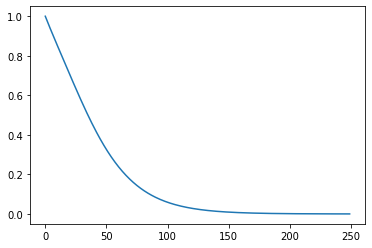

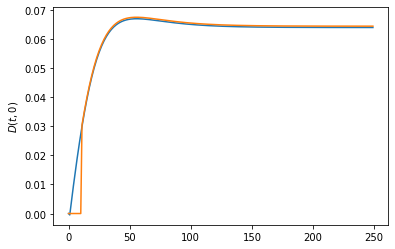

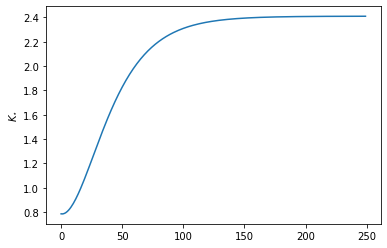

In [ ]:
# sweep over gamma
N = 512
gamma_vals = [0.5, 1.0, 2.0, 4.0]

all_Delta_var_expt = []
all_ft_var_expt = []
all_K_var_expt = []

all_Delta_var = []
all_ft_var = []
all_K_var = []

all_Delta = []
all_Delta_expt = []
all_K = []
all_K_expt = []
all_ft = []
all_ft_expt = []
# compute K_star
for i, gamma in enumerate(gamma_vals):
  Delta_expt, ft_expt, K_expt, K_expt_star, kappa_expt = init_and_train(N=N,gamma=gamma, eta0=eta,x=x,y=y, x_test=x_test,y_test=0.0, T=T, E = 5000) 
  print("xt * x = %0.4f | Kt = %0.4f" % ( jnp.dot(x, x_test)/D, Kt ))

  all_Delta_var_expt += [ N * Delta_expt.var(axis = 0) ]
  all_ft_var_expt += [N * ft_expt.var(axis = 0)]
  all_K_var_expt += [ N * K_expt.var(axis = 0) ]
  Delta, ft, K, K_star, Delta_cov, f_star_cov, K_cov, _, _ = solve_DMFT(y, Kt=Kt, eta=eta, gamma=gamma, iter = 100, samples = 3500, T=T, beta = 0.8)
  all_Delta_var += [ Delta_cov ]
  all_ft_var += [ f_star_cov ]
  all_K_var += [ K_cov ] 
  all_Delta += [Delta]
  all_Delta_expt += [Delta_expt.mean(axis = 0)]
  all_K += [K]
  all_K_expt += [K_expt.mean(axis = 0)]
  all_ft += [ft]
  all_ft_expt += [ft_expt.mean(axis = 0)]

In [ ]:
print(jnp.dot(x_test,x_test)/D)
print(jnp.dot(x,x)/D)
print(jnp.dot(x,x_test)/D) 
print(Kt)

1.0000001
1.0
0.51562256
0.51562256


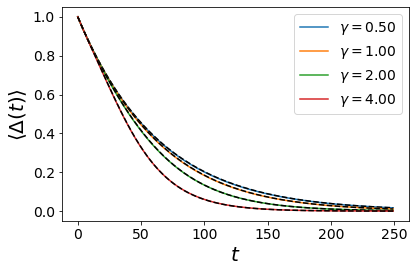

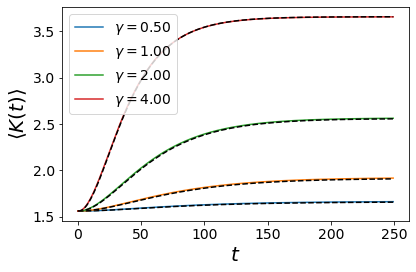

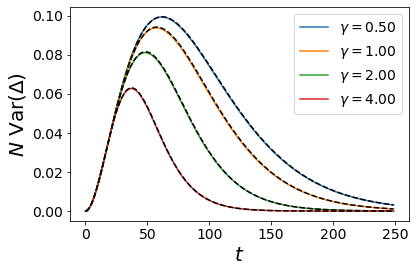

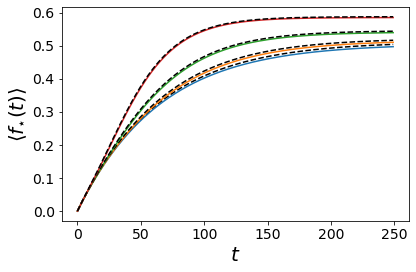

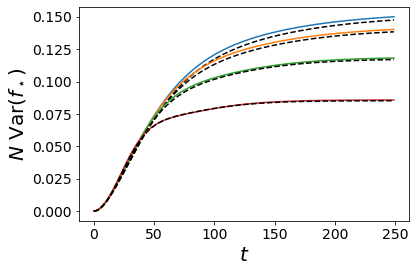

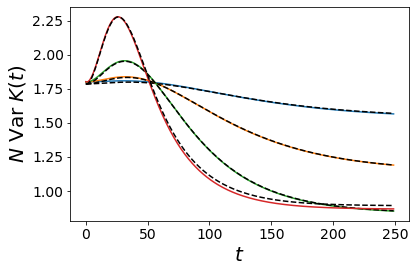

In [ ]:
plt.figure()
for i, gamma in enumerate(gamma_vals):
  plt.plot(all_Delta_expt[i], label = r'$\gamma = %0.2f$' % gamma)  
  plt.plot(all_Delta[i], '--', color = 'black')
plt.xlabel(r'$t$',fontsize =20)
plt.ylabel(r'$\left< \Delta(t) \right>$',fontsize=20)
plt.legend()
plt.tight_layout()
plt.savefig('train_pred_mean_vary_gamma_small_N.pdf')
plt.show()
plt.figure()

for i, gamma in enumerate(gamma_vals):
  plt.plot(all_K_expt[i], label = r'$\gamma = %0.2f$' % gamma)  
  plt.plot(all_K[i], '--', color = 'black')
plt.xlabel(r'$t$',fontsize =20)
plt.ylabel(r'$\left< K(t) \right>$',fontsize=20)
plt.legend()
plt.tight_layout()
plt.savefig('kernel_mean_vary_gamma_small_N.pdf')
plt.show()

plt.figure()
for i, gamma in enumerate(gamma_vals):
  plt.plot(all_Delta_var_expt[i], label = r'$\gamma = %0.2f$' % gamma)  
  plt.plot(all_Delta_var[i], '--', color = 'black')
plt.xlabel(r'$t$',fontsize =20)
plt.ylabel(r'$N$ Var$(\Delta)$',fontsize=20)
plt.legend()
plt.tight_layout()
plt.savefig('train_pred_var_vary_gamma_small_N.pdf')
plt.show()



plt.figure()
for i, gamma in enumerate(gamma_vals):
  plt.plot(all_ft[i])  
  plt.plot(-1.0*all_ft_expt[i], '--', color = 'black')
plt.xlabel(r'$t$',fontsize =20)
plt.ylabel(r'$\left< f_{\star}(t) \right>$',fontsize=20)
plt.tight_layout()
plt.savefig('test_pred_mean_vary_gamma_small_N.pdf')
plt.show()

plt.figure()
for i, gamma in enumerate(gamma_vals):
  plt.plot(all_ft_var_expt[i])  
  plt.plot(all_ft_var[i], '--', color = 'black')
plt.xlabel(r'$t$',fontsize =20)
plt.ylabel(r'$N$ Var$(f_\star)$',fontsize=20)
plt.tight_layout()
plt.savefig('test_pred_var_vary_gamma_small_N.pdf')
plt.show()


plt.figure()
for i, gamma in enumerate(gamma_vals):
  plt.plot(all_K_var_expt[i])  
  plt.plot(all_K_var[i], '--', color = 'black')
plt.xlabel(r'$t$',fontsize =20)
plt.ylabel(r'$N$ Var $K(t)$',fontsize=20)
plt.tight_layout()
plt.savefig('kernel_var_vary_gamma_small_N.pdf')
plt.show()

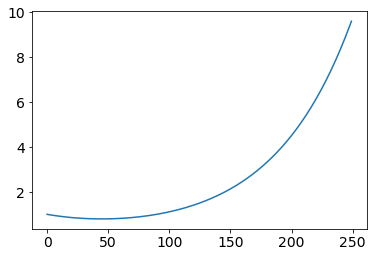

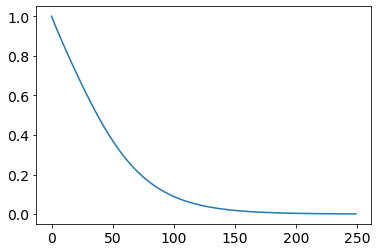

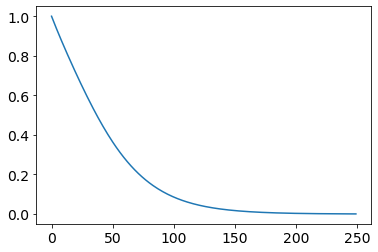

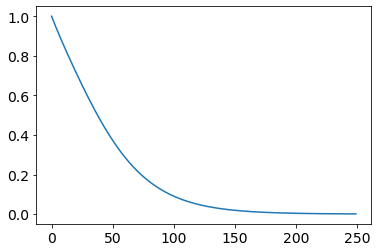

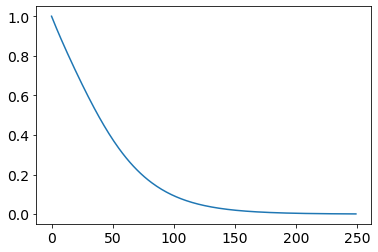

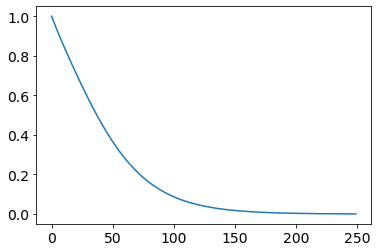

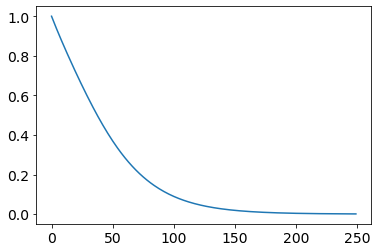

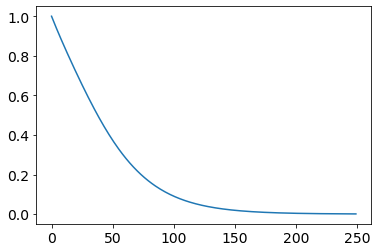

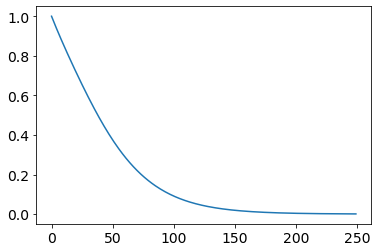

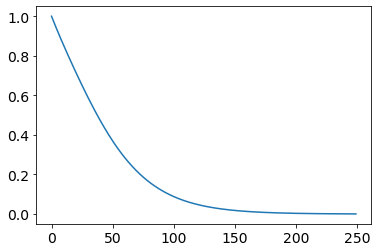

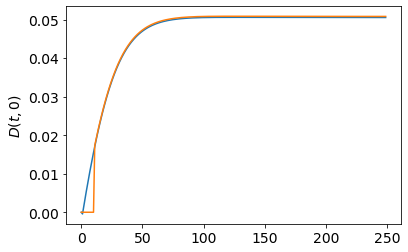

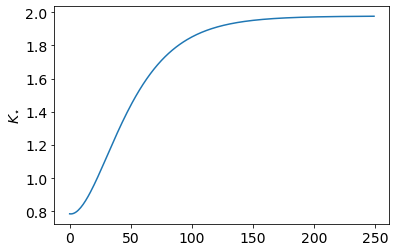

In [ ]:
Nvals = [1,2,5,10,25,50,100,250,500,1000,2500]
all_kernel_errs = []

gamma = 3.0
#for i, gamma in enumerate(gamma_vals):
kernel_errs_gamma = []
Delta_errs_gamma = []
ft_errs_gamma = []
kstar_errs_gamma = []

kernel_meanerrs_gamma = []
Delta_meanerrs_gamma = []
ft_meanerrs_gamma = []
kstar_meanerrs_gamma = []

Delta, ft, K, K_star, Delta_cov, f_star_cov, K_cov, _, _ = solve_DMFT(y, Kt=Kt, eta=eta, gamma=gamma, iter = 100, samples = 3500, T=T, beta = 0.8)
for j, N in enumerate(Nvals):
  Delta_expt, ft_expt, K_expt, K_expt_star, kappa_expt = init_and_train(N=N,gamma=gamma, eta0=eta,x=x,y=y, x_test=x_test, y_test=0.0, T=T, E = 5000) 
  kernel_errs_gamma += [ jnp.mean( (K[jnp.newaxis,:] - K_expt )**2 )]
  Delta_errs_gamma += [ jnp.mean( (Delta[jnp.newaxis,:] - Delta_expt)**2 ) ]
  ft_errs_gamma += [ jnp.mean( ( ft[jnp.newaxis,:] + ft_expt )**2 ) ]
  kstar_errs_gamma += [ jnp.mean( (K_star[jnp.newaxis,:] - K_expt_star )**2 )]
  kernel_meanerrs_gamma += [ jnp.mean( (K - K_expt.mean(axis = 0) )**2 )]
  Delta_meanerrs_gamma += [ jnp.mean( (Delta  - Delta_expt.mean(axis=0))**2 ) ]
  ft_meanerrs_gamma += [ jnp.mean( ( ft + ft_expt.mean(axis=0) )**2 ) ]
  kstar_meanerrs_gamma += [ jnp.mean( (K_star - K_expt_star.mean(axis=0) )**2 )]
#all_kernel_errs += [kernel_errs_gamma]



3.0


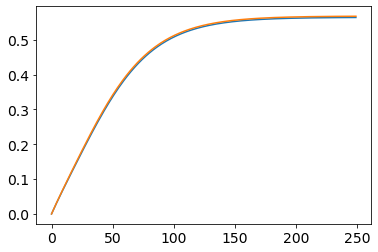

In [ ]:
print(gamma)
plt.plot(ft)
plt.plot(- ft_expt.mean(axis = 0))
plt.show()

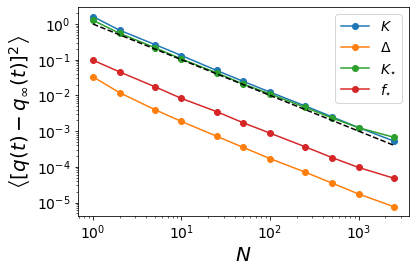

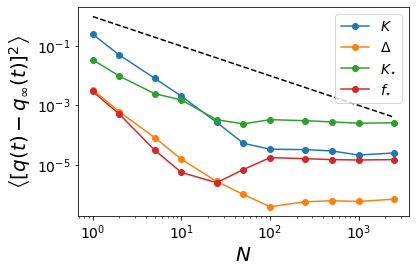

In [ ]:
plt.loglog(Nvals, kernel_errs_gamma, '-o', label = r'$K$')
plt.loglog(Nvals, Delta_errs_gamma, '-o', label = r'$\Delta$')
plt.loglog(Nvals, kstar_errs_gamma, '-o', label = r'$K_{\star}$')
plt.loglog(Nvals, ft_errs_gamma, '-o', label = r'$f_{\star}$')
plt.loglog(Nvals, jnp.array(Nvals)**(-1.0), '--', color = 'black')
plt.ylabel(r'$\left< \left[q(t) - q_{\infty}(t)\right]^2 \right>$',fontsize=20)
plt.xlabel(r'$N$',fontsize = 20)
plt.legend()
plt.tight_layout()
plt.savefig(r'N_scaling_kernel_var.pdf')
plt.show()

plt.loglog(Nvals, kernel_meanerrs_gamma, '-o', label = r'$K$')
plt.loglog(Nvals, Delta_meanerrs_gamma, '-o', label = r'$\Delta$')
plt.loglog(Nvals, kstar_meanerrs_gamma, '-o', label = r'$K_{\star}$')
plt.loglog(Nvals, ft_meanerrs_gamma, '-o', label = r'$f_{\star}$')
plt.loglog(Nvals, jnp.array(Nvals)**(-1.0), '--', color = 'black')
plt.ylabel(r'$\left< \left[q(t) - q_{\infty}(t)\right]^2 \right>$',fontsize=20)
plt.xlabel(r'$N$',fontsize = 20)
plt.legend()
plt.tight_layout()
plt.savefig(r'N_scaling_kernel_mean_err.pdf')
plt.show()

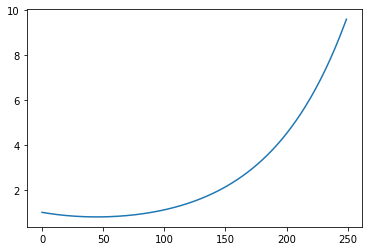

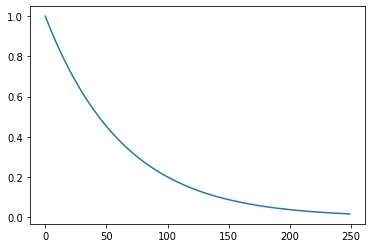

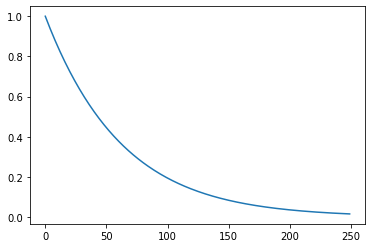

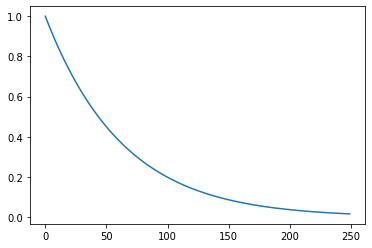

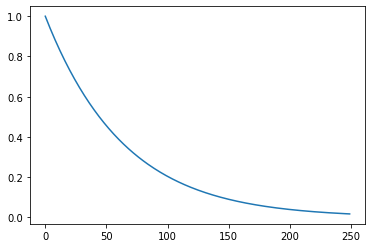

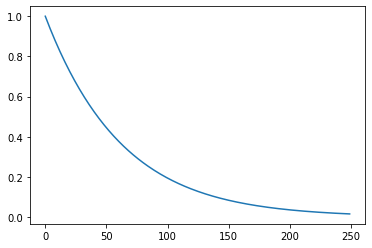

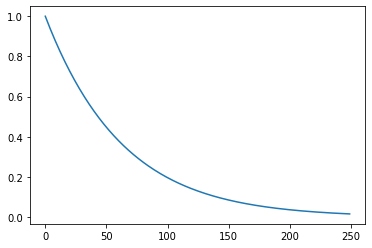

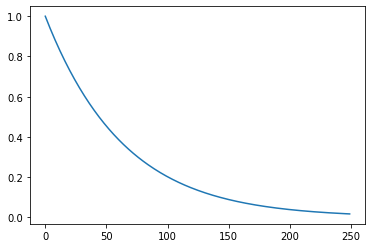

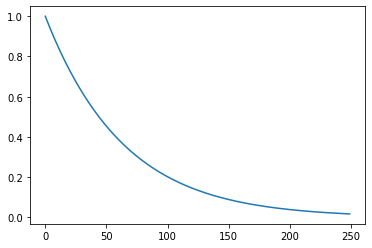

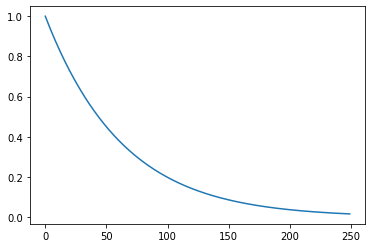

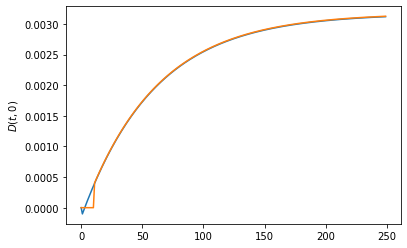

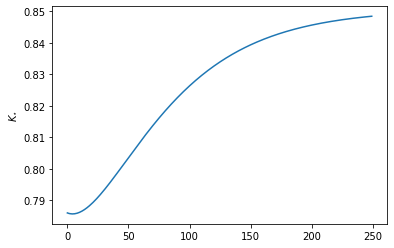

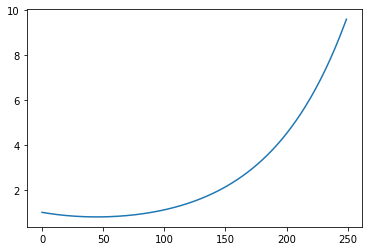

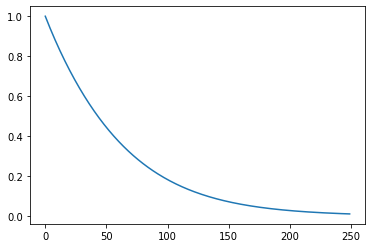

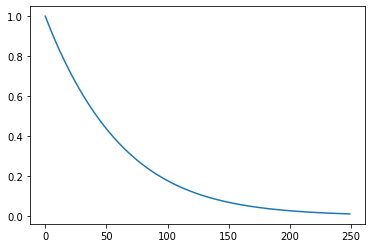

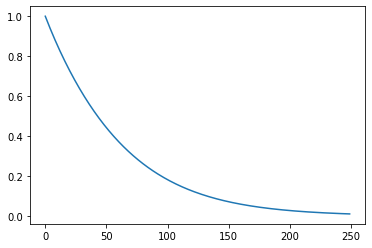

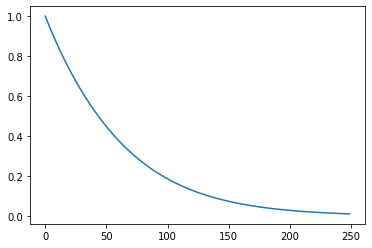

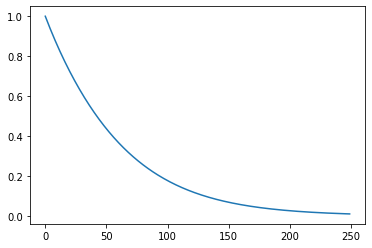

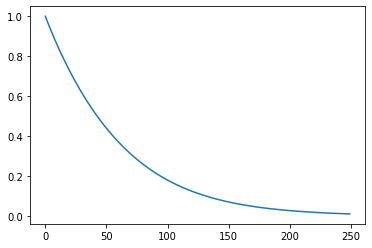

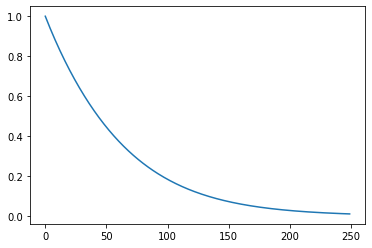

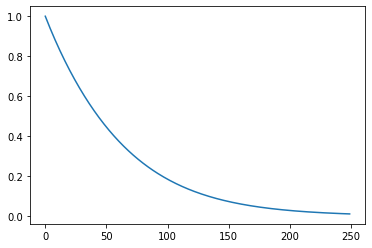

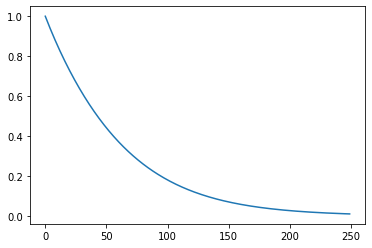

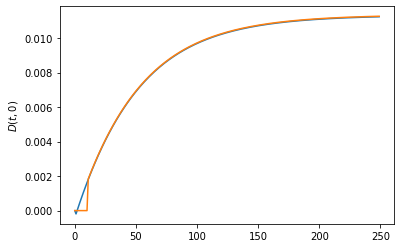

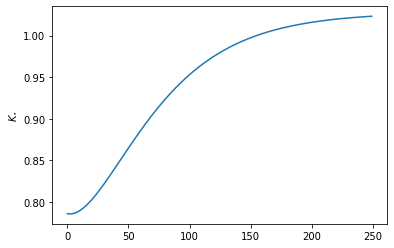

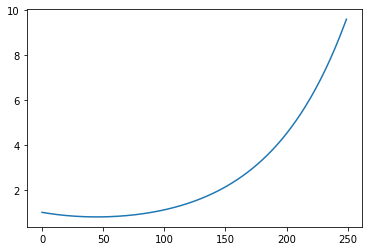

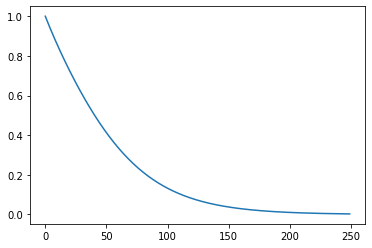

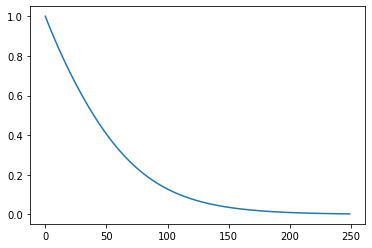

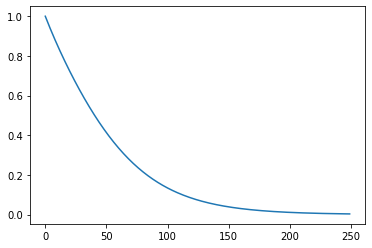

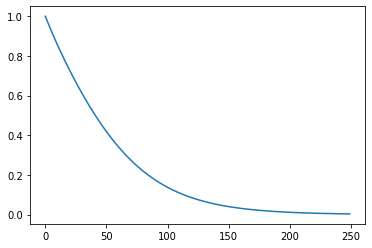

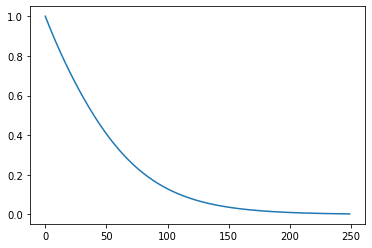

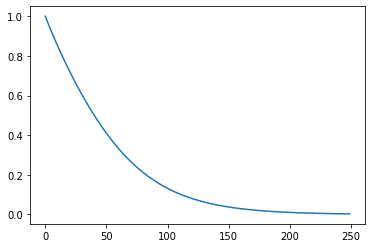

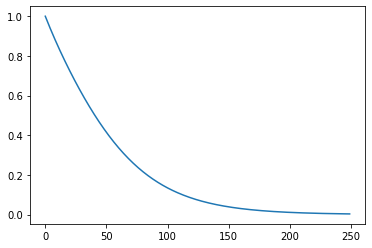

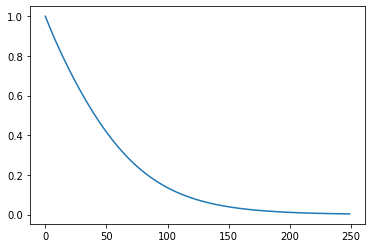

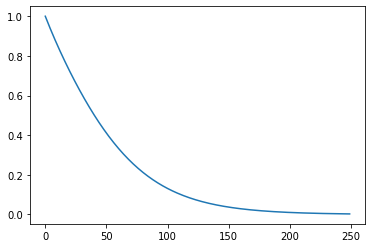

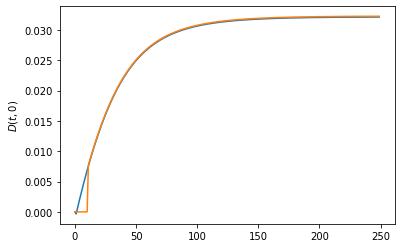

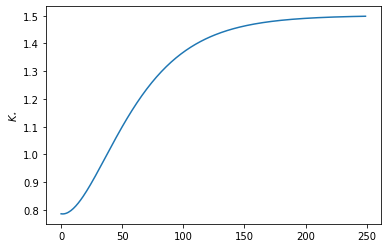

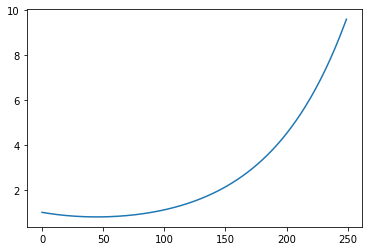

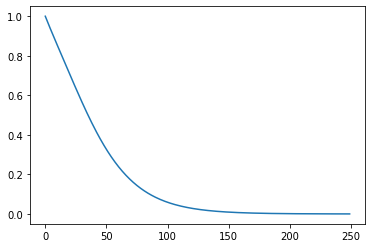

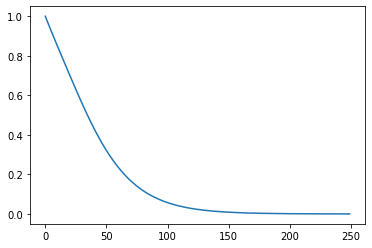

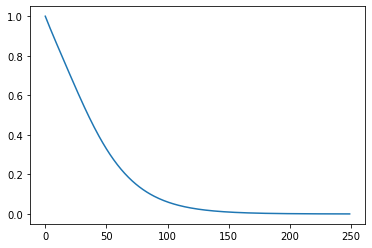

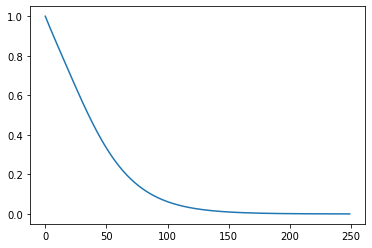

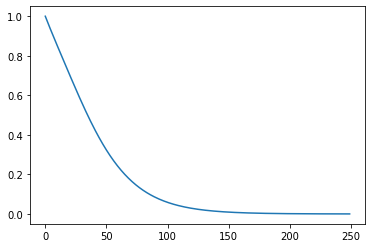

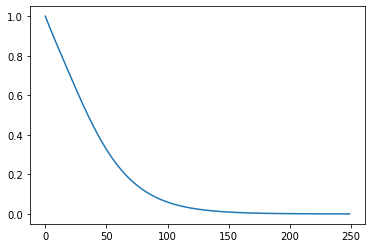

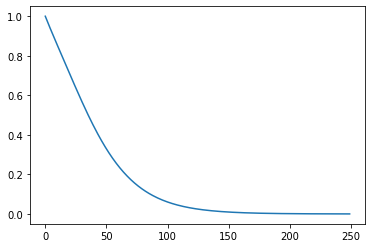

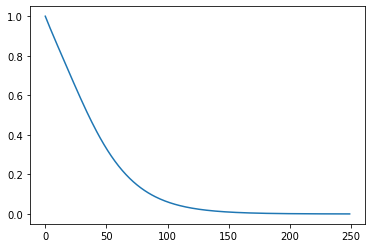

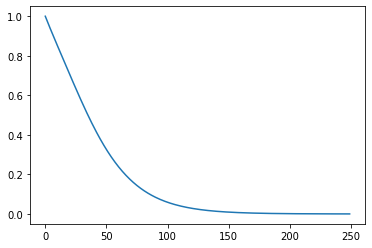

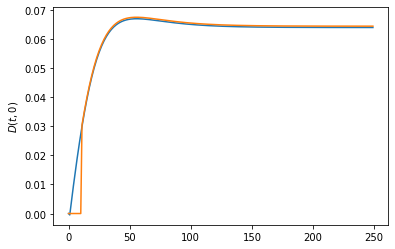

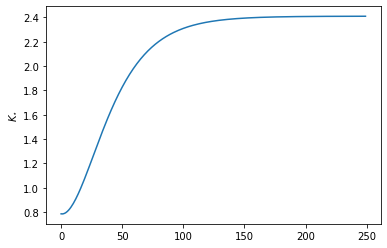

In [ ]:
gamma_vals = [0.5, 1.0, 2.0, 4.0]

all_kappa = []
all_D = []
all_Dt = []

# compute K_star
for i, gamma in enumerate(gamma_vals):
  Delta, ft, K, K_star, Delta_cov, f_star_cov, K_cov, K_star_cov, kappa, D, Dt = solve_DMFT(y, Kt=Kt, eta=eta, gamma=gamma, iter = 100, samples = 3500, T=T, beta = 0.8, return_D = True)
  all_kappa += [kappa]
  all_D += [D]
  all_Dt += [Dt]


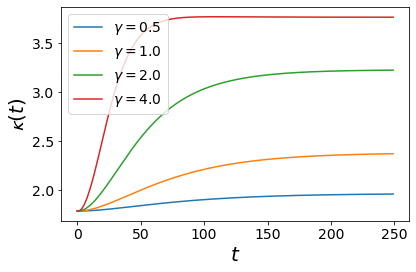

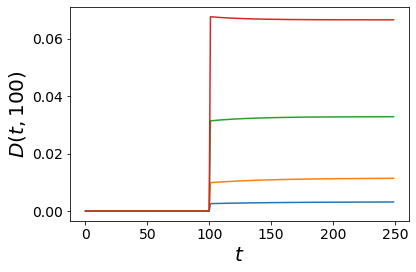

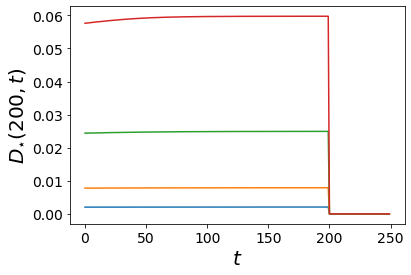

In [ ]:
plt.rcParams.update({'font.size': 14})
plt.figure()
for i, gamma in enumerate(gamma_vals):
  plt.plot(all_kappa[i], label = f'$\gamma = {gamma:0.1f}$')
plt.xlabel(r'$t$',fontsize = 20)
plt.ylabel(r'$\mathcal{\kappa}(t)$',fontsize =20)
plt.legend()
plt.tight_layout()
plt.savefig(r'kappa_vs_gamma_2layer.pdf')
plt.show()

for i, gamma in enumerate(gamma_vals):
  plt.plot(all_D[i][:,100])
plt.xlabel(r'$t$',fontsize = 20)
plt.ylabel(r'$D(t,100)$',fontsize =20)
plt.tight_layout()
plt.savefig(r'D_vs_gamma_2_layer.pdf')
plt.show()

for i, gamma in enumerate(gamma_vals):
  plt.plot(all_Dt[i][200,:])
plt.xlabel(r'$t$',fontsize = 20)
plt.ylabel(r'$D_{\star}(200,t)$',fontsize =20)
plt.show()

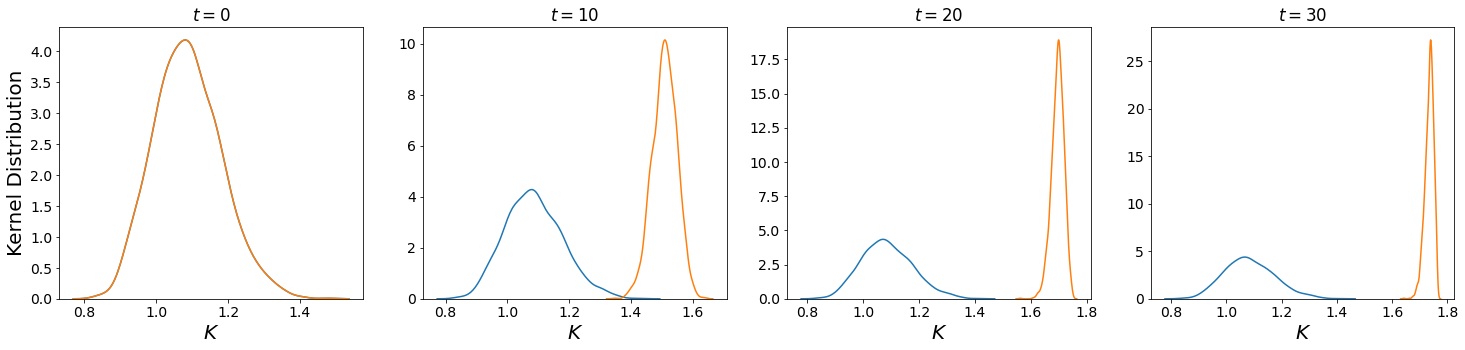

In [ ]:
import seaborn as sns

K_range = jnp.linspace(0.5,2.0)
plt.figure(figsize = (25,5))
for n in range(4):
  plt.subplot(1,4,n+1)
  sns.kdeplot(K_expt_lazy[:,10*n])
  sns.kdeplot(K_expt_rich[:,10*n])
  plt.title(r'$t = %d$' % (10*n)) 
  if n ==0:
    plt.ylabel('Kernel Distribution',fontsize = 20)
  else:
    plt.ylabel('')
  plt.xlabel(r'$K$',fontsize = 20)

plt.savefig('expt_kernel_dist.pdf')
plt.show()

In [ ]:
def sqrt_svd(M):
  s,v =jnp.linalg.eigh(M)
  s = s*(s>0.0)
  inds = jnp.argsort(s)[::-1]
  s = s[inds]
  v = v[:,inds]
  return v @ jnp.diag( s**(0.5) ) @ v.T
# two layer multi-sample equations
def compute_K_kappa(Kx, samples = 7500, seed = 0):
  sqrt_Kx = sqrt_svd(Kx)
  P = Kx.shape[0]
  u = random.normal(random.PRNGKey(seed), (samples,P)) @ sqrt_Kx
  r = random.normal(random.PRNGKey(seed+5), (samples,))
  phi_u = phi(u)
  dphi_u = dot_phi(u) 
  g = dphi_u * r[:,jnp.newaxis]
  Phi = 1/phi_u.shape[0] * phi_u.T @ phi_u
  G = 1/g.shape[0] * g.T @ g
  K = Phi + G * Kx
  # contributes to NTK K = \sum_{i} [ phi_i * phi_i + 
  k_s = jnp.einsum('ij,ik->ijk', phi_u, phi_u) + jnp.einsum('ij,ik->ijk',g, g)*Kx[jnp.newaxis,:,:] 
  kappa = jnp.einsum('ijk,ilm->jklm', k_s,k_s) / k_s.shape[0] - jnp.einsum('ij,kl->ijkl',K,K)
  return K, kappa

# theoretical curves for variance
def compute_lazy_theory_var(X, X_test, y, tvals, eta):

  Kxx= 1/X.shape[0]* X.T @ X
  #Kxt = 1/X.shape[0]* X.T @ X_test
  #Ktt = 1/X_test.shape[0] * X_test.T @ X_test
  P = X.shape[1]
  #Pt= X_test.shape[1]
  #Kx_tot = np.zeros((P+Pt, P+Pt))
  #Kx_tot[0:P,0:P] = Kxx
  #Kx_tot[0:P,P:] = Kxt
  #Kx_tot[P:,0:P] = Kxt.T
  #Kx_tot[P:,P:] = Ktt
  #Kx_tot = jnp.array(Kx_tot)

  K_tr, kappa_tr = compute_K_kappa(Kxx)

  kappa_flat = kappa_tr.reshape((P**2, P**2))
  s_kappa = jnp.linalg.eigvalsh(kappa_flat)

  print("minimum eigenvalue of flat kappa:")
  print(jnp.amin(s_kappa))
  #K_tr = K[0:P,0:P]
  #kappa_tr = kappa[:P,:P,:P,:P]
  #print(kappa_tr.shape)

  lambs, u = jnp.linalg.eigh(K_tr)
  lambs = lambs * (lambs > 0.0)

  inds = jnp.argsort(lambs)[::-1]
  lambs = lambs[inds]
  u = u[:,inds]

  plt.imshow(jnp.einsum('ijij->ij',kappa_tr), cmap='coolwarm')
  plt.show()
  

  # compute projection onto eigenbasis
  y_k = u.T @ y
  print("ykshape")
  print(y_k.shape)

  # express kappa to eigenbasis kappa_{kl k' l'} = < epsilon_{kl} epsilon_{k' l'} >
  kappa_k = jnp.einsum('im,ijkl->mjkl', u, kappa_tr) 
  kappa_k = jnp.einsum('jm,ijkl->imkl', u, kappa_k)
  kappa_k = jnp.einsum('km,ijkl->ijml', u, kappa_k)
  kappa_k = jnp.einsum('lm,ijkl->ijkm', u, kappa_k)

  tvals_scaled = tvals * eta / P # doing mean square error loss (divide by P)
  
  # compute functions of time
  # v_{kl}(t) = (e^{-lambda_k t} - e^{-lambda_l t}) / (lambda_l - lambda_k)
  eps = 1e-12
  V = np.zeros((P,P,T))
  for k in range(P):
    for l in range(P):
      if k == l:
        V[k,l,:] =  tvals_scaled * jnp.exp(- lambs[k] * tvals_scaled)
      else:
        V[k,l,:] = ( jnp.exp(-lambs[k]*tvals_scaled) - jnp.exp(-lambs[l]*tvals_scaled) ) / (lambs[l] - lambs[k] )
  
  plt.plot(V[1,1,:])
  plt.plot(V[1,2,:])
  plt.show()

  kappa_k_diag = jnp.einsum('ijik->ijk', kappa_k) # k x l x l' (since we only want trace of Sigma)
  Vy = jnp.einsum('ijk,j->ijk', V, y_k)

  # which way to contract over V? I guess V is symmetric
  kappa_V = jnp.einsum('ijk,ijl->ikl', kappa_k_diag, Vy)
  kappa_VV = jnp.einsum('ikl,ikl->il', kappa_V, Vy)

  Delta = jnp.exp(- jnp.einsum('i,j->ij', tvals_scaled, lambs) ) * y_k[jnp.newaxis,:]
  Delta = Delta @ u.T

  return kappa_VV, K_tr, Delta, kappa_tr

# K_var is the kernel variance (computed empirically, we will see if this works)
def compute_lazy_theory_var_given_kappa(X, X_test, y, K_mean, K_var, tvals, eta):

  Kxx= 1/X.shape[0]* X.T @ X
  #Kxt = 1/X.shape[0]* X.T @ X_test
  #Ktt = 1/X_test.shape[0] * X_test.T @ X_test
  P = X.shape[1]
  #Pt= X_test.shape[1]
  #Kx_tot = np.zeros((P+Pt, P+Pt))
  #Kx_tot[0:P,0:P] = Kxx
  #Kx_tot[0:P,P:] = Kxt
  #Kx_tot[P:,0:P] = Kxt.T
  #Kx_tot[P:,P:] = Ktt
  #Kx_tot = jnp.array(Kx_tot)

  #K_tr, _ = compute_K_kappa(Kxx)
  K_tr = K_mean
  kappa_tr = K_var
  #kappa_flat = kappa_tr.reshape((P**2, P**2))
  #s_kappa = jnp.linalg.eigvalsh(kappa_flat)

  #K_tr = K[0:P,0:P]
  #kappa_tr = kappa[:P,:P,:P,:P]
  #print(kappa_tr.shape)

  lambs, u = jnp.linalg.eigh(K_tr)
  lambs = lambs * (lambs > 0.0)
  inds = jnp.argsort(lambs)[::-1]
  lambs = lambs[inds]
  u = u[:,inds]

  plt.imshow(jnp.einsum('ijij->ij',kappa_tr), cmap='coolwarm')
  plt.show()
  

  # compute projection onto eigenbasis
  y_k = u.T @ y
  print("ykshape")
  print(y_k.shape)

  # u is samples x modes

  # express kappa to eigenbasis kappa_{kl k' l'} = < epsilon_{kl} epsilon_{k' l'} >
  kappa_k = jnp.einsum('im,ijkl->mjkl', u, kappa_tr) 
  kappa_k = jnp.einsum('jm,ijkl->imkl', u, kappa_k)
  kappa_k = jnp.einsum('km,ijkl->ijml', u, kappa_k)
  kappa_k = jnp.einsum('lm,ijkl->ijkm', u, kappa_k)

  tvals_scaled = tvals * eta / P # doing mean square error loss (divide by P)
  
  # compute functions of time
  # v_{kl}(t) = (e^{-lambda_k t} - e^{-lambda_l t}) / (lambda_l - lambda_k)
  eps = 1e-12
  V = np.zeros((P,P,T))
  for k in range(P):
    for l in range(P):
      if k == l:
        V[k,l,:] =  tvals_scaled * jnp.exp(- lambs[k] * tvals_scaled)
      else:
        V[k,l,:] = ( jnp.exp(-lambs[k]*tvals_scaled) - jnp.exp(-lambs[l]*tvals_scaled) ) / (lambs[l] - lambs[k] )
  
  plt.plot(V[1,1,:])
  plt.plot(V[1,2,:])
  plt.show()

  kappa_k_diag = jnp.einsum('ijik->ijk', kappa_k) # k x l x l' (since we only want trace of Sigma)
  Vy = jnp.einsum('ijk,j->ijk', V, y_k)

  # which way to contract over V? I guess V is symmetric
  kappa_V = jnp.einsum('ijk,ijl->ikl', kappa_k_diag, Vy)
  kappa_VV = jnp.einsum('ikl,ikl->il', kappa_V, Vy)

  Delta = jnp.exp(- jnp.einsum('i,j->ij', tvals_scaled, lambs) ) * y_k[jnp.newaxis,:]
  Delta = Delta @ u.T

  return kappa_VV, K_tr, Delta, kappa_tr

[ 1.  1.  1.  1. -1. -1. -1. -1.]
minimum eigenvalue of flat kappa:
-5.1477275e-07


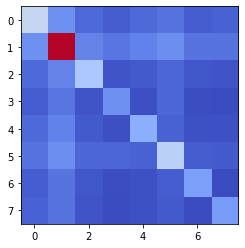

ykshape
(8,)


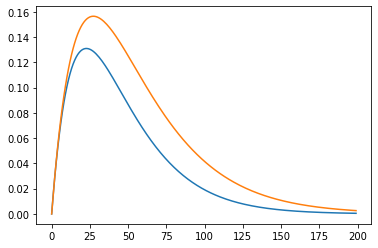

In [ ]:
P = 8
Pt = 5
D = 25
T = 200
eta = 0.125
X = random.normal(random.PRNGKey(0), (D, P))
Xt =  random.normal(random.PRNGKey(1), (D, Pt))
y = np.ones(P)
y[P//2:] = - y[P//2:]
#y = jnp.sign( random.normal(random.PRNGKey(2), (P,)))
print(y)
tvals = jnp.linspace(0,T,T)

# eta here is 0.1 * 0.5 = 0.05
Sigma, K_tr, Delta_th, kappa_tr = compute_lazy_theory_var(X, Xt, y, tvals, eta = eta)

In [ ]:
N = 100
gamma = 0.05
print(Xt.shape)
# eta0 here is 0.5
Deltas, K, kappa = init_and_train_no_test(N, gamma, eta0=eta, x=X, y=y, T=T, E = 800)


(25, 5)
multi


(800, 200, 8, 8)


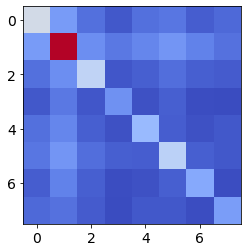

ykshape
(8,)


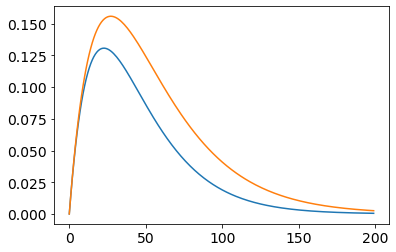

In [ ]:
print(K.shape)
K0 = K[:,0,:,:]
K_mean = jnp.einsum('ijk->jk', K0) / K0.shape[0]
K_var = N * ( jnp.einsum('ijk,ilm->jklm', K0, K0) / K0.shape[0] - jnp.einsum('ij,kl->ijkl', K_mean, K_mean) )

Sigma_est_var, _ , Delta_th, _ = compute_lazy_theory_var_given_kappa(X, Xt, y, K_mean, K_var, tvals, eta)


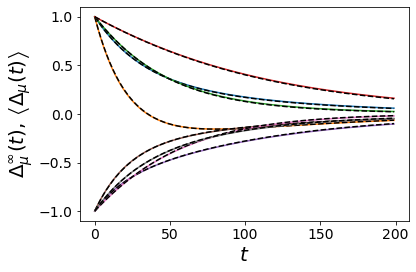

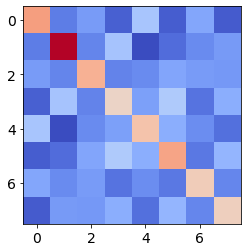

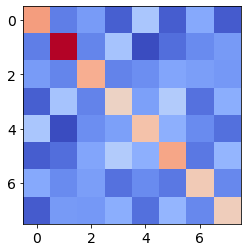

relative error
0.016212115


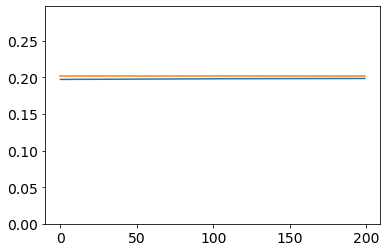

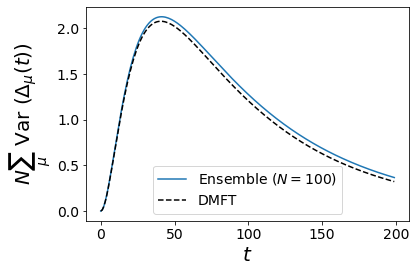

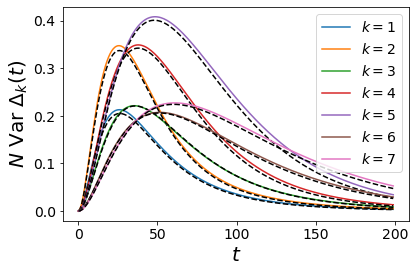

In [ ]:
var_Delta = Deltas.var(axis = 0)
#var_test = Deltas_test.var(axis=0)
plt.rcParams.update({'font.size': 14})

#plt.figure(figsize = (12,8))
for mu in range(X.shape[1]):
  plt.plot(Deltas.mean(axis = 0)[:,mu], color = 'C%d' % mu, label = r'$\mu = %d$' % mu)
  if mu == 0:
    plt.plot(Delta_th[:,mu], '--', color = 'black')
  else:
    plt.plot(Delta_th[:,mu], '--', color = 'black' )

plt.ylabel(r'$\Delta^{\infty}_{\mu}(t)$, $\left< \Delta_{\mu}(t) \right>$',fontsize =20)
plt.xlabel(r'$t$',fontsize =20)
#plt.legend()
plt.tight_layout()
plt.savefig(r'Delta_multi_sample.pdf')
plt.show()

plt.imshow(K_tr, cmap = 'coolwarm')
plt.show()
plt.imshow(K.mean(axis = (0,1)),cmap = 'coolwarm')
plt.show()

print("relative error")
print( jnp.linalg.norm(K_tr - K.mean(axis=(0,1))) / jnp.linalg.norm(K_tr) )

plt.plot(K.mean(axis = (0,2,3)) )
plt.plot(K_tr.mean() * jnp.ones(T))
plt.ylim([0,1.5*K.mean()])
plt.show()

#plt.plot(var_test.sum(axis=-1))
#plt.figure(figsize = (12,8))
plt.plot(N * var_Delta.sum(axis = -1), label = f'Ensemble ($N={N}$)')
plt.plot(Sigma.sum(axis=0),'--', color = 'black', label = r'DMFT')
#plt.plot(Sigma_est_var.sum(axis=0), '--', color = 'red', label = 'Est. DMFT')
plt.ylabel(r'$N \sum_{\mu}$ Var $(\Delta_\mu(t))$',fontsize = 20)
plt.xlabel(r'$t$',fontsize = 20)
plt.legend()
plt.tight_layout()
plt.savefig('train_err_var_contrib.pdf')
plt.show()

# transform Delta variance to new basis
eigs, u= jnp.linalg.eigh(K_mean)
inds = jnp.argsort(eigs)[::-1]
u = u[:,inds]
Deltas_eig_space = jnp.einsum('ijk,kl->ijl', Deltas, u)
Deltas_eig_var = Deltas_eig_space.var(axis = 0)
#plt.figure(figsize = (12,8))
for k in range(7):
  plt.plot(N * Deltas_eig_var[:,k], color = 'C%d' % k, label = r'$k = %d$' % (k+1))
  if k == 0:
    #plt.plot(Sigma[k,:], '--', color = 'C%d'% k, label = 'DMFT')
    plt.plot(Sigma_est_var[k,:], '--', color = 'black')
  else:
    #plt.plot(Sigma[k,:], '--', color = 'C%d'% k)
    plt.plot(Sigma_est_var[k,:], '--', color = 'black')
plt.xlabel(r'$t$',fontsize = 20)
plt.ylabel(r'$N$ Var $\Delta_k(t)$',fontsize=20)
plt.legend()
plt.tight_layout()
plt.savefig('var_eigspace_lazy.pdf')
plt.show()


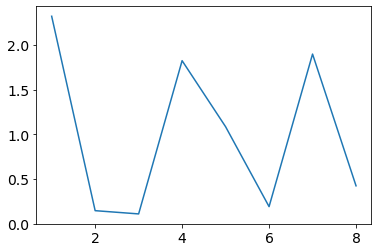

In [ ]:
s, v = jnp.linalg.eigh(K_mean)
yk = (v.T @ y)**2
plt.plot(jnp.linspace(1,len(yk),len(yk)), yk)
plt.show()

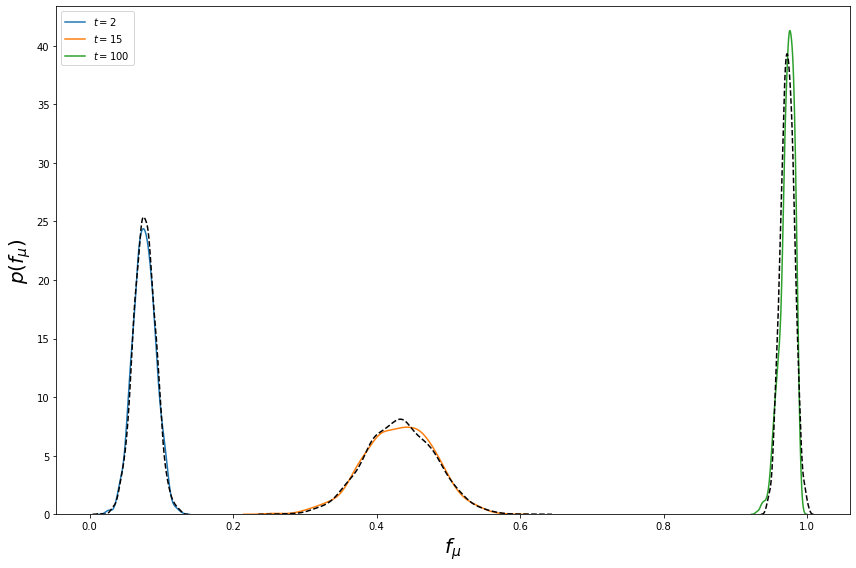

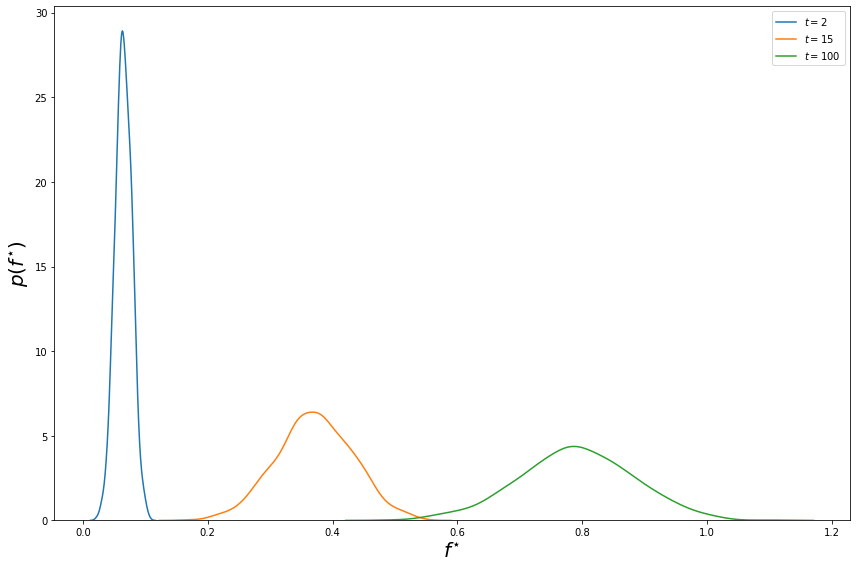

In [ ]:
import seaborn as sns

tvals = [2,15,100]
plt.figure(figsize = (12,8))

Deltas_5_mean = Deltas[:,:,5].mean(axis = 0)
Deltas_5_var = Deltas[:,:,5].var(axis = 0)
for i, t in enumerate(tvals):
  sns.kdeplot(y[5] - Deltas[:,t,5], label = r'$t = %d$' % t)
  samps_Delta = Deltas_5_mean[t] + random.normal(random.fold_in(random.PRNGKey(0), i), (2000,)) * jnp.sqrt(Deltas_5_var[t])
  sns.kdeplot(y[5]-samps_Delta, linestyle ='--', color = 'black')
plt.legend()
plt.xlabel(r'$f_{\mu}$',fontsize=20)
plt.ylabel(r'$p(f_{\mu})$',fontsize = 20)
plt.tight_layout()
plt.savefig('delta_train_dist_evolution.pdf')
plt.show()

tvals = [2,15,100]
plt.figure(figsize = (12,8))
for i, t in enumerate(tvals):
  sns.kdeplot(Deltas_test[:,t,5], label = r'$t = %d$' % t)
plt.legend()
plt.xlabel(r'$f^{\star}$',fontsize=20)
plt.ylabel(r'$p(f^{\star})$',fontsize = 20)
plt.tight_layout()
plt.savefig('delta_test_dist_evolution.pdf')
plt.show()



(800, 100, 8, 8)
0.21961688


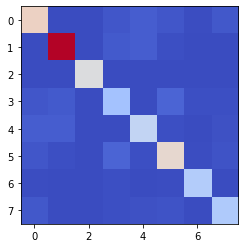

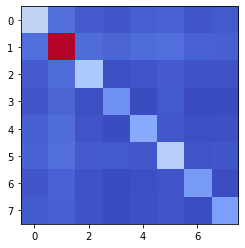

expt
[[1.57219    0.01248408 0.00493877]
 [0.01248408 2.767969   0.00944367]
 [0.00493877 0.00944367 1.3711517 ]]
theory
[[1.3154911  0.44696805 0.32522503]
 [0.44696805 2.9462454  0.42082688]
 [0.32522503 0.42082688 1.1413914 ]]


In [ ]:
print(K.shape)
K0 = K[:,0,:,:]

s, u  = jnp.linalg.eigh(K0)

kernel_var = jnp.einsum('ijk,ilm->jklm', K0, K0) / K0.shape[0]

print( jnp.mean((kernel_var-kappa_tr)**2) / jnp.mean((kernel_var)**2) ) 
plt.imshow(jnp.einsum('ijij->ij', kernel_var), cmap = 'coolwarm')
plt.show()
plt.imshow(jnp.einsum('ijij->ij', kappa_tr), cmap = 'coolwarm')
plt.show()



print("expt")
print(jnp.einsum('ijij->ij', kernel_var)[0:3,0:3])
print("theory")
print(jnp.einsum('ijij->ij', kappa_tr)[0:3,0:3])

In [ ]:
import jax.numpy as jnp
import numpy as np
from jax import random
import matplotlib.pyplot as plt

In [ ]:
def relu_kernel(theta):
  K = 1/jnp.pi*( jnp.sin(jnp.abs(theta)) + 2*(jnp.pi-jnp.abs(theta)) * jnp.cos(theta) )
  return K

def C0(theta):
  return 1.0/jnp.pi * (jnp.pi - jnp.abs(theta))

def C1(theta):
  return 1.0/jnp.pi * (jnp.sin(jnp.abs(theta)) + (jnp.pi-jnp.abs(theta))*jnp.cos(theta) )

def C2(theta):
  return 1.0/jnp.pi * (3*jnp.sin(jnp.abs(theta))*jnp.cos(theta) + (jnp.pi-jnp.abs(theta))*(1+2*jnp.cos(theta)**2) )

def variance(theta):
  K = 2
  K_s = relu_kernel(theta)
  
  kappa = 12
  #h3_hs = jnp.sin(theta)**2 * C1(theta) + 0.5*jnp.cos(theta) * C2(theta)
  #h2 = jnp.sin(theta)**2 * C0(theta) + jnp.cos(theta) * C1(theta)
  #kappa_s = 4 * h3_hs + 2*h2 + 4 * C0(theta)
  kappa_s = 6 * C0(theta) + 2 * C1(theta)
  kappa_s += 4 * jnp.sin(theta)**2 * C1(theta) + 2*jnp.cos(theta)*C2(theta) 
  kappa_s += 2*jnp.sin(theta)**2*C0(theta) + 2*jnp.cos(theta)*C1(theta)
  kappa_s += - K * K_s
  # kappa_s(0) = 4 * 0.5 * 3 + 1 + 7 = 6+1+4 = 11
  kappa_ss = 2 * C2(theta) + 4 * C1(theta) + 6*C0(theta) - K_s**2

  plt.plot(kappa*jnp.ones(len(theta)))
  plt.plot(kappa_s, '--')
  plt.plot(kappa_ss,'--')
  plt.show()
  # kappa_ss(0) = 6 + 4 + 6 - 4 = 12 (checks out) 
  return 1.0/K**4 * ( kappa * K_s**2 - 2*K*K_s * kappa_s + kappa_ss * K**2 )

def empirical_var(thetas, N=200, samples = 250):
  x = np.zeros(2)
  x[0] = 1.0
  xt = np.zeros((2, len(thetas)))
  xt[0,:] = np.cos(thetas)
  xt[1,:] = np.sin(thetas)
  Kxt = jnp.cos(thetas)
  plt.plot(Kxt)
  plt.show()
  key = random.PRNGKey(0)
  all_f = np.zeros((samples, len(thetas)))
  for n in range(samples):
    key, keyw, keya = random.split(key, 3)
    W = random.normal(keyw, (N,2))
    a = random.normal(keya, (N,))
    h = W @ x # N x 1
    phi = h * (h > 0.0)
    g = a * (h>0.0)
    hs = W @ xt # N x p_test
    phi_s = hs * (hs > 0.0)
    gs = a[:,np.newaxis] * (hs > 0.0)
    K = jnp.mean(phi**2) + jnp.mean(g**2)
    Ks = phi_s.T @ phi + (gs.T @ g/N) * jnp.cos(thetas)
    # df/dt = Ks Delta
    alpha = 1.0 / K 
    f = Ks / K
    all_f[n,:] = f
  return all_f



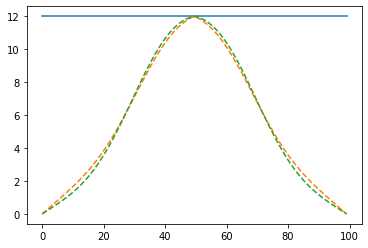

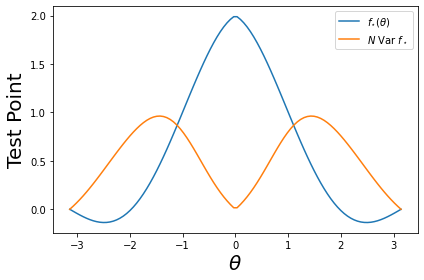

In [ ]:
thetas = jnp.linspace(-jnp.pi, jnp.pi, 100)
f_s = relu_kernel(thetas)
var_s = variance(thetas)
plt.plot(thetas, f_s, label= r'$f_{\star}(\theta)$')
plt.plot(thetas, var_s  , label = r'$N$ Var $f_\star$')
#plt.ylim([0,5])
plt.xlabel(r'$\theta$',fontsize=20)
plt.ylabel(r'Test Point',fontsize =20)
plt.legend()
plt.tight_layout()
plt.show()

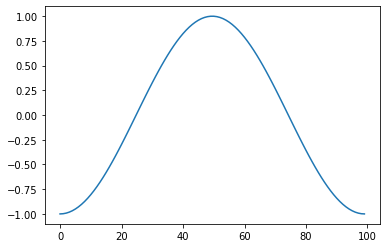

In [ ]:
all_f = empirical_var(thetas, N=200, samples = 250)

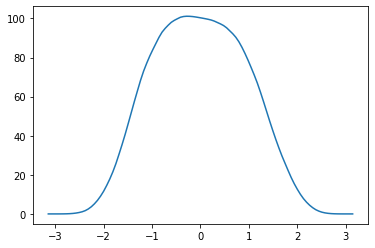

In [ ]:
plt.plot(thetas, all_f.var(axis=0))
plt.show()

In [ ]:
import jax.numpy as jnp
import numpy as np
from jax import random
import matplotlib.pyplot as plt

In [ ]:
def solve_catapult_DMFT_fluctuation(eta, gamma, T = 100):

  # first solve for Delta with DMFT equations

  f = 0.0
  y = 1.0
  K = 2.0
  ft = np.zeros(T)
  Kt = np.zeros(T)
  for t in range(T):
    ft[t] = f
    Kt[t] = K
    df = eta * K * (y - f) + eta**2 * gamma**2 * f * (y-f)**2
    dK = 4 * eta * gamma**2 * f * (y-f) + eta**2 * gamma**2 * (y-f)**2 * K
    f = f + df
    K = K + dK

  Delta = y - ft
  Theta = jnp.tril(jnp.ones((T,T)), k = -1)
  Theta_Delta = jnp.einsum('ij,j->ij', Theta, Delta)
  
  vp = jnp.linalg.solve( jnp.eye(T) - eta * gamma * Theta_Delta, jnp.ones(T) )
  vm = jnp.linalg.solve( jnp.eye(T) + eta * gamma * Theta_Delta, jnp.ones(T) )

  Theta_Delta_inv_Theta_p = jnp.linalg.inv( jnp.eye(T) - eta * gamma * Theta_Delta ) @ Theta
  Theta_Delta_inv_Theta_m = jnp.linalg.inv( jnp.eye(T) + eta * gamma * Theta_Delta ) @ Theta  

  kappa_f = 0.25* ( jnp.outer(vp,vp) + jnp.outer(vm,vm) )**2 + 0.25*( jnp.outer(vp,vp) - jnp.outer(vm,vm) )**2

  D = eta * gamma * Theta_Delta_inv_Theta_p * jnp.outer(vp,vp) + eta * gamma * Theta_Delta_inv_Theta_m * jnp.outer(vm,vm)

  D_K = 2*eta * gamma * Theta_Delta_inv_Theta_p * jnp.outer(vp,vp) - 2*eta * gamma * Theta_Delta_inv_Theta_m * jnp.outer(vm,vm)

  kappa_fK = (jnp.outer(vp,vp) + jnp.outer(vm,vm)) * (jnp.outer(vp,vp) - jnp.outer(vm,vm))
  kappa_K = (jnp.outer(vp,vp) + jnp.outer(vm,vm))**2 + (jnp.outer(vp,vp) - jnp.outer(vm,vm))**2

  # now promote to 4*T x 4*T for variables (f, K, hat{f}, hat{K})
  H = np.zeros((4*T, 4*T))
  H[2*T:3*T,0:T] = gamma * np.eye(T) + D # d/d(hat{f} df
  H[0:T,2*T:3*T] = gamma * np.eye(T) + D.T # d/df d/dhat{f}
  
  H[3*T:,0:T] = D_K # d/dhat{K} d/f
  H[0:T,3*T:] = D_K.T # d/d{hat f} d/d K
  
  H[T:2*T,3*T:] = np.eye(T) # d/dK d/dhat{K}
  H[3*T:,T:2*T] = np.eye(T) # d/dhat{K} d/d

  # now enter all kappa blocks
  H[2*T:3*T,2*T:3*T] = kappa_f #
  H[2*T:3*T,3*T:] = kappa_fK
  H[3*T:,2*T:3*T] = kappa_fK.T 
  H[3*T:,3*T:] = kappa_K
  
  prop = jnp.linalg.inv(H)
  return Delta, Kt, - prop[0:T,0:T], -prop[T:2*T,T:2*T]

def finite_catapult(N, eta, gamma, T=20, E = 100):

  Delta = np.zeros((T, E))
  K = np.zeros((T,E))
  u = random.normal(random.PRNGKey(0), (N,E))
  r = random.normal(random.PRNGKey(1), (N,E))
  h = 1.0 * u
  z = 1.0 * r
  for t in range(T):
    Delta[t,:] = 1.0 -  1.0 / gamma * jnp.mean(h*z, axis = 0) 
    K[t,:] = jnp.mean( h**2 + z**2, axis = 0)
    dh = eta * gamma * jnp.einsum('ij,j->ij', z, Delta[t,:] )
    dz = eta * gamma * jnp.einsum('ij,j->ij', h, Delta[t,:] )
    h += dh
    z += dz
  return Delta, K

In [ ]:
eta = 0.2
gamma = 2.5
T = 25
Delta, K, Sigma_f, Sigma_K = solve_catapult_DMFT_fluctuation(eta, gamma, T = T)

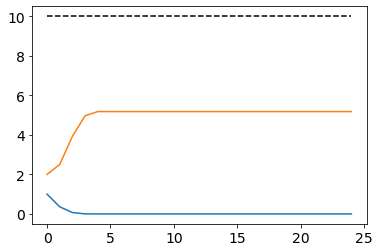

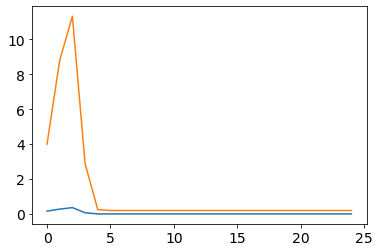

In [ ]:
plt.plot(Delta**2)
plt.plot(K)
plt.plot(np.ones(len(K)) * 2/eta, '--', color = 'black')
plt.show()

plt.plot(jnp.diag(Sigma_f))
plt.plot(jnp.diag(Sigma_K))
plt.show()

In [ ]:
N = 3200

Delta_expt, K_expt = finite_catapult(N, eta, gamma, T=T, E = 100)

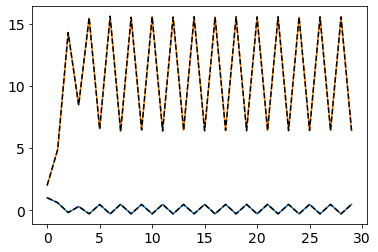

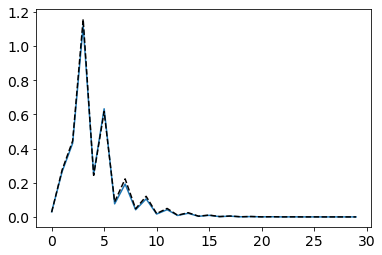

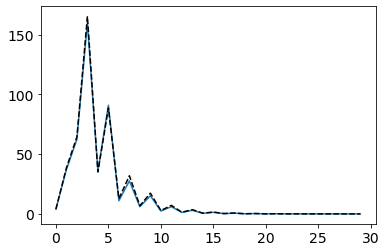

In [ ]:
plt.plot(Delta_expt.mean(axis = 1))
plt.plot(K_expt.mean(axis = 1))
plt.plot(Delta, '--', color = 'black')
plt.plot(K, '--', color = 'black')
#plt.plot(2/eta * jnp.ones(T))
plt.show()

plt.plot(N * Delta_expt.var(axis = 1))
plt.plot(jnp.diag(Sigma_f), '--', color = 'black')
plt.show()

plt.plot(N * K_expt.var(axis = 1))
plt.plot(jnp.diag(Sigma_K), '--', color = 'black')
plt.show()

In [ ]:
eta = 1.0/5.0
gamma_vals = [1.0, 2.0, 3.0, 4.0, 5.0, 5.5, 6.0]
T = 30
all_Delta = []
all_Delta_var = []
all_Delta_expt = []
all_Delta_expt_var = []
all_K = []
all_K_var = []
all_K_expt = []
all_K_expt_var = []
for i, gamma in enumerate(gamma_vals):
  Delta, K, Sigma_f, Sigma_K = solve_catapult_DMFT_fluctuation(eta, gamma, T = T)
  all_Delta += [Delta]
  all_Delta_var += [jnp.diag(Sigma_f)]
  all_K += [ K ]
  all_K_var+= [ jnp.diag(Sigma_K) ]


  Delta_expt, K_expt = finite_catapult(N, eta, gamma, T=T, E = 300)
  all_Delta_expt += [Delta_expt.mean(axis = 1)]
  all_K_expt += [ K_expt.mean(axis = 1) ] 
  all_Delta_expt_var += [ N * Delta_expt.var(axis = 1)]
  all_K_expt_var += [N * K_expt.var(axis = 1)]

0.2


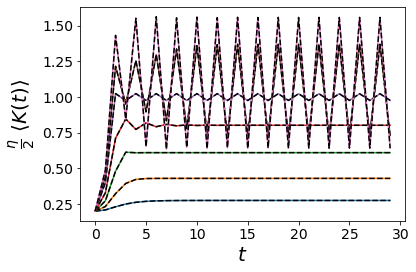

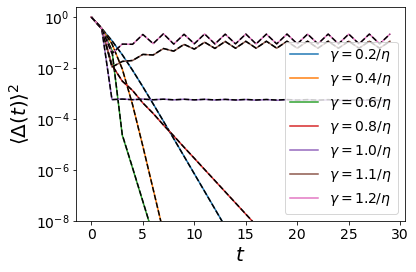

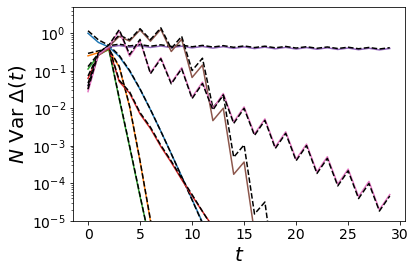

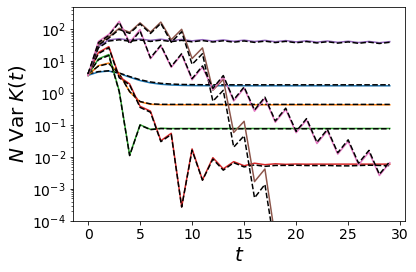

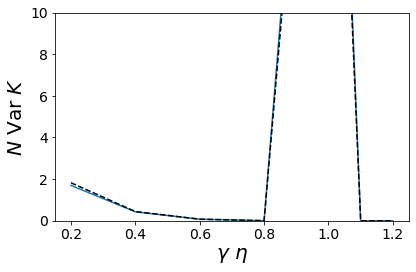

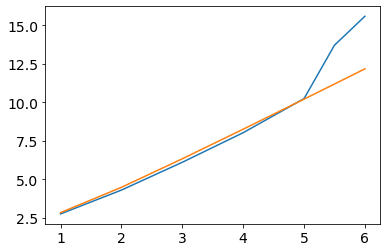

In [ ]:
print(eta)
for i,K in enumerate(all_K):
  plt.plot(jnp.array(all_K_expt[i]) *eta /2 ) 
  plt.plot(K * eta /2.0, '--', color = 'black')

plt.xlabel(r'$t$',fontsize=20)
plt.ylabel(r'$\frac{\eta}{2} \ \left< K(t) \right>$',fontsize = 20)
plt.tight_layout()
plt.savefig('mean_kernel_dynamics_catapult.pdf')
plt.show()

for i,Delta in enumerate(all_Delta):
  plt.semilogy(all_Delta_expt[i]**2,  label = r'$\gamma = %0.1f /  \eta$' % (gamma_vals[i] * eta) )
  plt.semilogy(Delta**2, '--', color = 'black')
plt.legend()
plt.xlabel(r'$t$',fontsize=20)
plt.ylabel(r'$\left<\Delta(t) \right>^2$',fontsize = 20)
plt.ylim([1e-8, 2.5])
plt.tight_layout()
plt.savefig('mean_err_dynamics_catapult.pdf')
plt.show()

for i,Delta_var in enumerate(all_Delta_var):
  plt.semilogy(Delta_var)
  plt.semilogy(all_Delta_expt_var[i], '--', color = 'black')
plt.ylim([1e-5,5.0])
plt.xlabel(r'$t$',fontsize=20)
plt.ylabel(r'$N$ Var $\Delta(t)$',fontsize = 20)
plt.tight_layout()
plt.savefig('err_var_dynamics_catapult.pdf')
plt.show()


for i, K_var in enumerate(all_K_var):
  plt.semilogy(all_K_expt_var[i])
  plt.semilogy(K_var, '--', color = 'black')
plt.ylim([1e-4,500])
plt.xlabel(r'$t$',fontsize=20)
plt.ylabel(r'$N$ Var $K(t)$',fontsize = 20)
plt.tight_layout()
plt.savefig('kernel_var_dynamics_catapult.pdf')
plt.show()


plt.plot(np.array(gamma_vals) * eta, [Kvar[-2] for Kvar in all_K_expt_var])
plt.plot(np.array(gamma_vals) * eta, [Kvar[-2] for Kvar in all_K_var], '--', color = 'black')
plt.xlabel(r'$\gamma \ \eta$',fontsize=20)
plt.ylabel(r'$N$ Var $K$',fontsize = 20)
plt.ylim([0,10])
plt.tight_layout()
plt.savefig('kernel_variance_vs_gamma_catapult.pdf')
plt.show()

plt.plot(gamma_vals, [ jnp.mean(K[-2:-1]) for K in all_K])
plt.plot(gamma_vals, 2*jnp.sqrt(1+jnp.array(gamma_vals)**2))
#plt.plot(gamma_vals, 2/eta * jnp.ones(len(gamma_vals)) )
plt.show()

